# Instalar e importar Pacotes

In [ ]:
# Instalação de pacotes
!pip install shap
!pip install catboost
!pip install BorutaShap
# Pacote para verificar outlier com a biblioteca PyOD
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 21.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=166fe9cedc67f976ced6b97630bbd5de9b5cc20ec958b30beb006add6fe5cc9c
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [ ]:
# Importação de Pacotes
import pandas as pd
import shap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as ltb
import pickle
import scipy.stats
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.preprocessing import MinMaxScaler,RobustScaler,OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter
from scipy.stats import describe,loguniform,wilcoxon
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve,precision_recall_curve,roc_auc_score,auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.model_selection import cross_val_score,cross_validate,GridSearchCV
from sklearn.model_selection import RandomizedSearchCV,KFold,StratifiedKFold
from sklearn.model_selection import ShuffleSplit,StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from BorutaShap import BorutaShap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pyod.models.knn import KNN
from IPython.display import display, HTML
import math
import copy

In [ ]:
pd.set_option('max_colwidth', -1)

# Funções de apoio (utils) para as classes

**Funções para Split e configuração de scores**

In [ ]:
def executargridsearch(model,params,X_,y_,scores='f1_macro',silent='N'):
  folds = config_experimento.num_folds
  param_comb = 10
  skf = definesplit(num_folds=folds,rand_state=42)
  #StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
  random_search = RandomizedSearchCV(model,
                                     param_distributions=params,
                                     n_iter=param_comb,
                                     scoring='f1_macro',
                                     n_jobs=4,
                                     cv=skf.split(X_,y_),
                                     verbose=3,
                                     random_state=42)
  # random_search = GridSearchCV(model,param_grid = params,scoring='f1_macro',
  #                               cv = skf.split(X_,y_),n_jobs=4,verbose=3)

  random_search.fit(X_, y_)
  if silent == 'N':
    print('   Best normalized gini score for %d-fold search:' % 
          (folds),random_search.best_score_)
    print('   Best hyperparameters:',random_search.best_params_)
  results = pd.DataFrame(random_search.cv_results_)

  return random_search

In [ ]:
def definesplit(num_folds,rand_state,Predict=False):
  # Mais apropriado para dados desbalanceados
  if (config_experimento.Tiposplit == 2) or (Predict):
    split = StratifiedKFold(n_splits=num_folds, shuffle=True, 
                            random_state=rand_state)
  else:
    split =  RepeatedStratifiedKFold(n_splits=num_folds,
                                     n_repeats=config_experimento.n_repeats, random_state=42)
  return split

In [ ]:
def evaluate_model(model, X, y, scores, n_splits=5, n_repeats=30):
    cv = RepeatedStratifiedKFold(n_splits=n_splits,
                                 n_repeats=n_repeats, random_state=42)

    scores_result = cross_validate(model, X, y, scoring=scores,
                             cv=cv, n_jobs=-1, error_score='raise',
                             return_estimator=True)

    return scores_result

In [ ]:
def definedf_result():
    names = []
    for modelo in config_experimento.modelos:
      names.append(modelo['nome_classificador'])
    nrows = 2
    # (config_experimento.num_folds * config_experimento.n_repeats)
    ncols =  len(names)
    results = pd.DataFrame(np.zeros((nrows,ncols)), columns=names)
    iterables = [list(names), config_experimento.scores]
    mult_idx = pd.MultiIndex.from_product(iterables, names=["CLF", "SCORE"])
    nrows = len(mult_idx)
    df_results = pd.DataFrame(np.zeros((nrows,2)),
                              index=mult_idx)
    return df_results

In [ ]:
def set_scores_result(df_results, scores_result, model_name):
  vmetfresult= ['accuracy','precision','recall','f1','roc_auc']
  vmetcross  = ['vacuracia','vprecisao','vrecall','vf1','vroc']
  vmetteste  = ['vaccmodelkfold','vprecmodelkfold','vrecallmodelkfold',
                'vf1modelkfold','vrocaucmodelkfold']

  for index in range(len(vmetfresult)):
    df_results.loc[model_name, 
      vmetfresult[index]][0]=np.mean(scores_result[vmetcross[index]])
    df_results.loc[model_name, 
      vmetfresult[index]][1]=np.mean(scores_result[vmetteste[index]])

**Funções para gerar gráficos**

In [ ]:
def matriz_confusao(y_test, y_predict,modelo,nome):
    matriz_conf = confusion_matrix(y_test, y_predict)
    fig = plt.figure()
    ax = plt.subplot()
    sns.heatmap(matriz_conf, annot=True, cmap='Blues', ax=ax,fmt='g');
    ax.set_xlabel('Valor Predito');
    ax.set_ylabel('Valor Real');
    ax.set_title('Matriz de Confusão - '+nome);
    #ax.xaxis.set_ticklabels(modelo.classes_);
    #ax.yaxis.set_ticklabels(modelo.classes_);
    ax.xaxis.set_ticklabels([0,1]);
    ax.yaxis.set_ticklabels([0,1]);
    #plt.close()
    plt.show()
    return fig

In [ ]:
def plota_heatmap(X_):
  plt.figure(figsize=(20,20))
  plt.rcParams.update({'font.family' :'sans-serif',
                              'font.weight': 'bold','font.size': 10})
  sns.heatmap(X_.corr(method='spearman'),vmin=-1,vmax=1,fmt='.2g',annot=True,cmap='YlGnBu')

In [ ]:
def montargraficoevasao(dfnumevadidos,x_='curso',nomecurso=''):
  font = {'family' : 'serif',
              'color'  : 'darkred',
              'weight' : 'bold',
              'size'   : 20,
              }
  plt.figure(figsize=(50, 6))
  plt.rcParams.update({'font.family' :'sans-serif',
                              'font.weight': 'bold','font.size': 20})

  ax = dfnumevadidos.plot(x=x_,y=['evadidos','totalturma'],kind = 'bar',figsize=(20, 10),
                    fontsize=15,rot=15,color={'evadidos': 'tomato','totalturma':'lightblue'})
  # plt.title("Situação de evasão por "+x_+" - "+nomecurso,fontdict=font)

  plt.ylabel("Qtde alunos",fontdict=font)
  plt.xlabel(x_,fontdict=font)
  x_offset = -0.08
  y_offset = 0.50
  for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
  plt.savefig("graficoevasao.pdf", format='pdf',dpi=300, bbox_inches = 'tight')
  plt.show()
  plt.close()

In [ ]:
def graficoevasao_periodo(df_,nomevar_y = 'situacao'):
  # Padrão de evasão por período
  font = {'family' : 'serif',
                'color'  : 'darkred',
                'weight' : 'normal',
                'size'   : 15,
                }
  evasao_periodo = df_[(df_[config_experimento.var_y] == 1)].groupby(
      ['periodo_modulo',config_experimento.var_y],
      as_index=False)['curso'].count()
  bottom, height = .25, .5
  plt.figure(figsize=(50, 6))
  ax = evasao_periodo.plot(x='periodo_modulo',y=['curso'],kind = 'bar',
                           figsize=(20, 10),
                           fontsize=15,rot=15,color={'curso':'royalblue'})
  plt.title("Evasão por Período_módulo",fontdict=font)

  plt.ylabel("Qtde Evadidos",fontdict=font)
  plt.xlabel("Período_Módulo",fontdict=font)
  for p in ax.patches:
          txt = "{:.2f}".format(p.get_height().round(1)/evasao_periodo['curso'].sum()*100) + '%'
          txt_x = p.get_x()
          txt_y = p.get_height()
          x_offset = 0
          y_offset = 1
          b = p.get_bbox()
          ax.annotate(txt, ((b.x0) + x_offset, b.y1 + y_offset))
          #ax.text(txt_x,txt_y,txt)
  ax.legend(['% Evadidos'])
  plt.show()

In [ ]:
def boxplot_sorted(modelos_,resultadosmodel, metric, by=['Technique'], 
                   rot=90, figsize=(18,8), fontsize=24, section=''):
    df2  = pd.DataFrame({modelos_[i]:resultadosmodel[i]
                         [metric] for i in range(0,len(modelos_))})
    meds = df2.median().sort_values(ascending=False)
    axes = df2[meds.index].boxplot(figsize=figsize, rot=rot, 
                                   fontsize=fontsize,
                                   boxprops=dict(linewidth=4, 
                                                 color='cornflowerblue'),
                                   whiskerprops=dict(linewidth=4, 
                                                     color='cornflowerblue'),
                                   medianprops=dict(linewidth=4, 
                                                    color='firebrick'),
                                   capprops=dict(linewidth=4, 
                                                 color='cornflowerblue'),
                                   flierprops=dict(marker='o',
                                        markersize=12,
                                         markeredgecolor='black'),
                                   return_type="axes")

    str_by = '_'.join([str(s) for s in by])
    str_title = 'Boxplots da metrica %s por %s'
    axes.set_title(str_title % (metric,str_by), fontsize=fontsize+4)

    # Save figure
    figname = str.lower(f'boxplot_{section}_top_{str_by}_{metric}' +'.pdf')
    plt.savefig(figname, format='pdf', bbox_inches = 'tight')
    plt.show()
    plt.close()

In [ ]:
def plotresult(crossval, tests, metrica,section=''):
  plt.figure(figsize=(24,10))
  plt.clf()
  plt.plot(range(len(crossval)),crossval,
          label="Cross_validate por iteração com RepeatedStratifiedKFold")
  plt.plot(range(len(tests)),tests,
          label="Teste por iteração train_test_split (30%,shuffle e stratify em target)")
  plt.xlabel("iterações")
  plt.ylabel(metrica)
  plt.legend()
  figname = str.lower(f'Iteracoescrossval_{section}_{metrica}' +'.pdf')
  plt.savefig(figname, format='pdf', bbox_inches = 'tight')
  plt.show()
  plt.close()

In [ ]:
def histplotX(X_):
  plt.rcParams.update({'font.family' :'sans-serif',
                       'font.weight': 'bold','font.size': 10})

  vnrows = math.ceil(len(X_.columns)/4)
  fig, axes = plt.subplots(nrows = vnrows, ncols = 4)
  axes = axes.flatten()
  fig.set_size_inches(20, 20)

  for ax, col in zip(axes, X_.columns):
    sns.histplot(X_[col], ax = ax,kde=True)

In [ ]:
def plotadispersao(finalDf_):
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1)
  ax.set_xlabel('Componente Principal 1', fontsize = 15)
  ax.set_ylabel('Componente Principal 2', fontsize = 15)
  ax.set_title('Dois componentes PCA', fontsize = 20)
  targets = [0, 1]
  #colors = ['r', 'g', 'b']
  colors = ['r', 'g']
  for target, color in zip(targets,colors):
      indicesToKeep = finalDf_[config_experimento.var_y] == target
      ax.scatter(finalDf_.loc[indicesToKeep, 'principal_component_1']
                , finalDf_.loc[indicesToKeep, 'principal_component_2']
                , c = color
                , s = 50)
  ax.legend(targets)
  ax.grid()
  plt.show()

In [ ]:
def plota_auc(y_testpred, previsao_mod):
  # Compute False postive rate, and True positive rate
  fpr, tpr, thresholds =roc_curve(y_testpred, previsao_mod)
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('', vauc))

  # Custom settings for the plot
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('1-Specificity(False Positive Rate)')
  plt.ylabel('Sensitivity(True Positive Rate)')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()   # Display

  # Compute False postive rate, and True positive rate
  fpr, trc, thresholds=precision_recall_curve(y_testpred, previsao_mod)
  vauc = auc(trc, fpr)
  print("AUC-PR ",vauc)
  plt.plot(fpr, trc, label='%s AUCPR (area = %0.2f)' % ('', vauc))

  # Custom settings for the plot
  no_skill = len(y_testpred[y_testpred==1]) / len(y_testpred)
  plt.plot([0, 1], [no_skill, no_skill],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall (Positive Label: 1)')
  plt.ylabel('Precision (Positive Label: 1)')
  plt.title('Precision-Recall curve')
  plt.legend(loc="lower right")
  plt.show()   # Display

# Classe Singleton para configuração dos experimentos

In [ ]:
class Configexperimento:

  def __init__(self):
    self.featuresselecionadas = None
    self.scores = ['accuracy','recall','f1','precision','roc_auc','recall_macro']
    self.modelos = []
    self.var_y = 'situacao'
    self.combalanceamento = True
    self.comnormalizacao = False
    self.Tiposplit = 1
    self.otimizahiperparametros = False
    self.num_folds=5
    self.n_repeats=3
    self.perc_train = 0.70
    self.perc_test = 0.30
    self.remove_outlier = True


  def adiciona_modelo(self,modelo):
    idx = [i for i, j in
           enumerate(self.modelos) if j['nome_classificador'] == modelo['nome_classificador']]
    if len(idx) > 0:
      self.modelos[idx[0]] = modelo
    else:
      self.modelos.append(modelo)

  def deleta_modelo(self,nomemodelo):
    idx = [i for i, j in
           enumerate(self.modelos) if j['nome_classificador'] == nomemodelo]
    if len(idx) > 0:
      self.modelos.pop(idx[0])

  def defval_cfg_modelo(self,nomemodelo,cfg,valor):
    idx = [i for i, j in
           enumerate(self.modelos) if j['nome_classificador'] == nomemodelo]
    if len(idx) > 0:
      self.modelos[idx[0]][cfg] = valor
    else:
      print('Nenhum Valor Alterado')

  def retval_cfg_modelo(self,nomemodelo,cfg):
    idx = [i for i, j in
           enumerate(self.modelos) if j['nome_classificador'] == nomemodelo]
    if len(idx) > 0:
      return self.modelos[idx[0]][cfg]
    else:
      return None

  def info(self):
    print("Features selecionadas:",self.featuresselecionadas)
    print("Métricas utilizadas..:",self.scores)
    print("Variável Alvo........:",self.var_y)
    print("Executa balanceamento:",self.combalanceamento)
    print("Normalização.........:",self.comnormalizacao)
    print("Remove outliers......:",self.remove_outlier)
    print("Utiliza otimiz Parâm.:",self.otimizahiperparametros)
    print("Tipo Split de dados .:",self.Tiposplit)
    print("N_repeats Stratified.:",self.n_repeats)
    print("K_folds Stratified...:",self.num_folds)
    print("Perc.Treinamento.....:",self.perc_train)
    print("Perc.Teste...........:",self.perc_test)
    print("Classificadores......:")
    for modelo in self.modelos:
      print(modelo)
    

In [ ]:
config_experimento = Configexperimento()

# Classe para análise exploratória dos dados

In [ ]:
class Engaja_analise_Expl:
  
  def __init__(self,nomevarevasao='situacao',
                    nomevarcurso='curso',nomevaraluno='aluno'):
    self.nomevarevasao = nomevarevasao
    self.nomevarcurso = nomevarcurso
    self.nomevaraluno = nomevaraluno

  def __calcula_perc(self,linha):
    return "{:.2f}".format(linha['evadidos']/linha['totalturma']*100)
  
  def __verificadados(self,df_,features_):
    if (df_ is None):
      raise Exception("DataFrame Não pode estar vazio")
    if ((features_ is None) or 
        not(type(features_) is list)):
      raise Exception("Lista de Features não pode estar vazia "+
                      "e precisa ser do tipo list")

  def plota_situacao_evasao(self,df_):
    self.__verificadados(df_,config_experimento.featuresselecionadas)

    dfnumevadidos_ = pd.DataFrame((df_.where(df_[self.nomevarevasao] == 1)).
                                groupby([self.nomevarcurso],
                                        as_index=False)[self.nomevaraluno].agg(['nunique']))
    dftotalturma_ = df_.groupby([self.nomevarcurso])[self.nomevaraluno].agg(['nunique'])
    vnumevadidos = []
    dftotalturma_ = dftotalturma_.reset_index()
    dftotalturma_ = dftotalturma_.rename(columns={'nunique':'totalturma'})
    dfnumevadidos_ = dfnumevadidos_.reset_index()
    dfnumevadidos_=dfnumevadidos_.rename(columns={'nunique':'evadidos'})
    for (i,row) in dftotalturma_.iterrows():
      vct = dfnumevadidos_[dfnumevadidos_[self.nomevarcurso] == row[self.nomevarcurso]].count()[0]
      if vct > 0:
        vnumevadidos.append(dfnumevadidos_[dfnumevadidos_[self.nomevarcurso] == 
                                          row[self.nomevarcurso]]['evadidos'].values[0])
      else:
        vnumevadidos.append(0)

    dftotalturma_['evadidos'] = vnumevadidos
    dftotalturma_ = dftotalturma_[dftotalturma_[self.nomevarcurso] != '99999']
    dadoscursos = dftotalturma_
    montargraficoevasao(dftotalturma_,self.nomevarcurso)
    dadoscursos['perc_evadidos'] = dadoscursos.apply(self.__calcula_perc, axis=1)
    display(HTML(dadoscursos.head().to_html()))

  def plota_estat_dados(self,df_):
    self.__verificadados(df_,config_experimento.featuresselecionadas)
    display(HTML(df_.loc[:,config_experimento.featuresselecionadas].describe().to_html()))
    plota_heatmap(df_.loc[:,config_experimento.featuresselecionadas])

  def plota_hist_dados(self,df_):
    histplotX(df_.loc[:,config_experimento.featuresselecionadas])

# Classes composite para Pré-processamento

In [ ]:
import abc
class Component(metaclass=abc.ABCMeta):

    def __init__(self):
      self.silent = 'S'
    
    def get_silent(self):
      return self.silent
    
    def set_silent(self,valor):
      self.silent = valor

    @abc.abstractmethod
    def realiza_operacao(self,X_,y_):
        pass

class Preprocessamento(Component):

    def __init__(self):
        super().__init__()
        self._children = []
    
    def realiza_operacao(self,X_,y_):
        for child in self._children:
          child.silent = super().get_silent()
          X_,y_ = child.realiza_operacao(X_,y_)

        return X_,y_

    def add(self, component):
      idx = [i for i, j in
           enumerate(self._children) if type(component) is type(j)]
      if len(idx) > 0:
        self._children[idx[0]]=component
      else:
        self._children.append(component)

    def remove(self, component):
      idx = [i for i, j in
           enumerate(self._children) if type(component) is type(j)]
      if len(idx) > 0:
        self._children.pop(idx[0])
    
    def retira_acento(self,frase_):
      nome = frase_.upper()
      retiraacentos = [
          ['.', ''],['Á','A'],['À','A'],['Ê','E'],['Ô','O'],['Û','U'],
          ['Õ','O'],['É','E'],['Í','I'],['Ç','C'],['Ü','U'],['Ä','A'],
          ['Â','A'],['Ã','A'],['Ó','O'],['Ú','U']
      ]

      for acento in retiraacentos:
        nome = nome.replace(acento[0],acento[1])

      return nome
   
    def apaga_instancias(self,nomecampo,conteudo,df_):
      df_ = df_.drop(df_[df_[nomecampo].str.strip() == conteudo].index, axis=0)
      return df_

    def renomear_conteudo_campo(self,nome_ant,nome_novo,df_,nomecampo='curso'):
      df_[nomecampo] = df_[nomecampo].replace(nome_ant,nome_novo)      
      return df_

**Classe para detecção de outliers**
(Detectando Outlier com Boxplot e biblioteca PyOD)

In [ ]:
class Engaja_outliers(Component):

  def __init__(self,df = None):
    super().__init__()
    self.lista_outliers = None
    self.__outliers = []
    self.__df_ = df
    self.__X_ = self.__df_.loc[:,config_experimento.featuresselecionadas]
    self.__y_ = self.__df_.loc[:,config_experimento.var_y]
    # if (self.__df_ is None):
    #   raise Exception("DataFrame Não pode estar vazio")
  
  def __definepca(self,ncomp,X_):
    pca = PCA(n_components=ncomp)
    x = StandardScaler().fit_transform(X_)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                , columns = ['principal_component_1', 'principal_component_2'])
    print(pca.explained_variance_ratio_)
    return principalDf
  
  def __define_outlier(self):
    # Distância Euclidiana
    knn_pipeline = Pipeline(steps=[
      ("normalizacao", MinMaxScaler()),
      ("KNN", KNN())
    ])
    detector = knn_pipeline
    detector.fit(self.__X_)
    return detector
  
  def __verifica_outlier_dados(self):
    detector = self.__define_outlier()
    ## Plota dispersão da base original
    finalDf = pd.concat([self.__definepca(2,self.__X_), self.__y_], axis = 1)
    print("Dispersão da base original")
    plotadispersao(finalDf)
    previsoes_outlier = detector['KNN'].labels_
    for i in range(len(previsoes_outlier)):
      if previsoes_outlier[i] == 1:
        self.__outliers.append(i)
    self.lista_outliers = self.__df_.iloc[self.__outliers,:]
    #Remoção de outlier e nova plotagem da base original
    Xtemp = self.__df_.drop(self.__outliers,axis=0).loc[:,config_experimento.featuresselecionadas]
    ytemp = self.__df_.drop(self.__outliers,axis=0)[config_experimento.var_y]
    
    finalDf = pd.concat([self.__definepca(2,Xtemp), ytemp], axis = 1)
    print("Dispersão depois de remoção de outliers")
    plotadispersao(finalDf)
    #return self.lista_outliers,self.__outliers
  
  def salvar_lista_outliers(self,nomearquivo='outliers.xlsx'):
    # Salva Lista de Outlier
    if self.lista_outliers is None:
      print('Sem dados para salvar. Chame o método "realiza_operacao" '+
      'para gerar a lista')
    else:
      self.lista_outliers.to_excel(nomearquivo,float_format="%.3f",  encoding = 'utf8')
      print('Lista de outliers salva com sucesso no arquivo "'+nomearquivo+'"')
  
  def remove_outliers(self):
    if config_experimento.remove_outlier:
      return self.__df_.drop(self.__outliers,axis=0)
    else:
      return self.__df_
  
  def realiza_operacao(self,X_,y_):
    if config_experimento.remove_outlier:
      print("\n-----Detecção e remoção de outliers-----")
      self.__X_ = X_
      self.__y_ = y_
      self.__verifica_outlier_dados()
      print("Concluído!")
      return self.__X_.drop(self.__outliers,axis=0),self.__y_.drop(self.__outliers,axis=0)
    else:
      return X_,y_

**Classes de balanceamento e normalização de dados**

In [ ]:
class Engaja_balanceamento(Component):

  def __init__(self):
    super().__init__()
    
  # Oversampling
  def realiza_operacao(self,X_,y_):
    if config_experimento.combalanceamento:
      if super().get_silent() == 'N':
        print("\n-----Balanceamento dos dados com SMOTE-----")
      smote = SMOTE(sampling_strategy='auto',random_state=2)
      X_over, y_over = smote.fit_resample(X_,y_)
      if super().get_silent() == 'N':
        print(Counter(y_),Counter(y_over))
        print("Concluído!")
      return X_over, y_over
    else:
      if super().get_silent() == 'N':
        print("\n-----Sem balanceamento de dados configurado -----")
      return self.X_, self.y_  

In [ ]:
class Engaja_normalizacao(Component):

  def __init__(self,tp=1):
    super().__init__()
    self.tp = tp

  def realiza_operacao(self,X_,y_):
    if config_experimento.comnormalizacao:
      print("\n-----Normalização dos dados para treinamento-----")
      columns_to_standardize = config_experimento.featuresselecionadas
      if self.tp == 1:
        min_max_scaler = MinMaxScaler()
      else:
        min_max_scaler = RobustScaler()

      for column in columns_to_standardize:
        X_[column] = min_max_scaler.fit_transform(
            np.array(X_[column]).reshape(-1,1))
      print("Concluído!")
    else:
      print("\n-----Sem normalização configurada para este classificador-----")

    return X_,y_

# Classe XAI com Shap (Gráficos)

In [ ]:
class Engaja_Xai:

  def __init__(self,modelo,X_train,y_train):
    self.normalizamodelo = False
    self.__modelo  = modelo
    self.__normalizacao = Engaja_normalizacao()
    self.__X_train = X_train
    self.__y_train = y_train
    self.__flgexplainer = 0    
    plt.rcParams.update({'font.family' :'sans-serif',
                                'font.weight': 'bold','font.size': 22})
  
  def __salvarfigura(self,nome,formato,plt,dpi=None):
    plt.savefig(nome+"."+formato,bbox_inches="tight",dpi=dpi,format=formato)
  
  ################ Aplica SHAP no modelo treinado ##################
  def efetua_xaimodelo_global(self,section,nomemodelo,complots='S'):
    print("\n-----Efetuando cálculo de Shap Values para os "+
          "dados de treinamento-----")
    
    self.__vparam_shap = config_experimento.retval_cfg_modelo(nomemodelo,
                                                            'params_shap')
    print("Modelo: ",nomemodelo)
    check_additivity=self.__vparam_shap['check_additivity']

    if self.__vparam_shap['tipo_explainer'] != 'tree':
      self.__explainer = shap.Explainer(self.__modelo.predict_proba, self.__X_train,
                                feature_names=self.__X_train.columns)
      self.__shap_values = self.__explainer(self.__X_train)
      self.__shap_valuesw = self.__shap_values
    else:
      self.__explainer = shap.TreeExplainer(self.__modelo,
                                          self.__X_train,
                                          model_output=
                                          self.__vparam_shap['param_proba'])
      self.__shap_values = self.__explainer(self.__X_train,
                                        check_additivity=check_additivity)
      self.__shap_valuesw = self.__explainer.shap_values(self.__X_train)
    if complots == 'S':
      self.plota_sumario_beeswarm(section,tpgraph=0)
      self.plota_sumario_bardend(section,tpgraph=0)
    self.__flgexplainer = 1
    print("Concluído!")

################ Análise importância Local com Plots ##################
  def __plota_xaimodelo_local(self,instancia,tpgraph=1,frtsaving = 'png'):
    if self.__flgexplainer == 0:
      self.efetua_xaimodelo_global(self,'Análise Importância Local',
                                   complots='N')
    shap_values = self.__explainer(instancia)

    fig = plt.figure(figsize=(200, 150))
    if self.__vparam_shap['dim_shapvalues'] == 1:
      shap.plots.force(shap_values[0,:,1],
                       matplotlib=True,show=False,text_rotation=12)
      if tpgraph == 1:
        self.__salvarfigura("xaiind",frtsaving,plt,
                   600 if frtsaving == 'png' else None)
      plt.show()
      shap.plots.waterfall(shap_values[0,:,1],
                           show=False,max_display=15)
      if tpgraph == 1:
        self.__salvarfigura("xaiind_waterfall",frtsaving,plt,
                   600 if frtsaving == 'png' else None)
      plt.show()
    else:
      shap.plots.force(shap_values[0],
                       matplotlib=True,show=False,text_rotation=12)
      self.__salvarfigura("xaiind",frtsaving,plt,
                   600 if frtsaving == 'png' else None)
      plt.show()
      shap.plots.waterfall(shap_values[0],
                           show=False,max_display=15)
      self.__salvarfigura("xaiind_waterfall",frtsaving,plt,
                   600 if frtsaving == 'png' else None)
      plt.show()

  ########################
  def executa_xai_local(self,nomecampo,conteudocampo,dfpredicteste_,
                        frtsaving,tpgraph=1,campodisciplina='disciplina'):
    vdadosnovosaluno = dfpredicteste_[dfpredicteste_[nomecampo] == 
                                      conteudocampo]

    if self.normalizamodelo:
      self.__normalizacao.silent ='S'
      config_experimento.comnormalizacao = self.normalizamodelo
      vdadosnovosaluno = self.__normalizacao(vdadosnovosaluno,None)

    for (i,row) in vdadosnovosaluno.iterrows():
      print('Pesquisa de',nomecampo,':',
            conteudocampo,'Disciplina: ',row[campodisciplina])
      self.__plota_xaimodelo_local(
          row[config_experimento.featuresselecionadas].to_frame().T,frtsaving)
      
  ###################### Plots Análise importância Global #####################
  def __make_shap_waterfall_plot(self,shap_values, features, num_display=20):
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / 
                     np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]

    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4

    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)

    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))

  ##################
  def plota_sumario_beeswarm(self,section,tpgraph=1,frtsaving = 'png'):
    if self.__flgexplainer == 0:
      self.efetua_xaimodelo_global(self,section,complots='N')

    if self.__vparam_shap['dim_shapvalues'] == 1:
      shap.summary_plot(self.__shap_values[:,:,1], 
                        self.__X_train,plot_type='violin',show=False)
      if tpgraph == 1:
        self.__salvarfigura("Xaiglogal_beeswarm_"+section,frtsaving,plt,
                    600 if frtsaving == 'png' else None)
      plt.show()
    else:
      shap.summary_plot(self.__shap_values,self.__X_train,plot_type='violin',
                        show=False,plot_size=[10.5,7])
      if tpgraph == 1:
        self.__salvarfigura("Xaiglogal_beeswarm_"+section,frtsaving,plt,
                    600 if frtsaving == 'png' else None)
      plt.show()

  ##################
  def plota_sumario_bar(self,section,tpgraph=1,frtsaving = 'png'):
    if self.__flgexplainer == 0:
      self.efetua_xaimodelo_global(self,section,complots='N')

    if self.__vparam_shap['dim_shapvalues'] == 1:
      shap.summary_plot(self.__shap_values[:,:,1], self.__X_train,
                        plot_type='bar',show=False)
      if tpgraph == 1:
        self.__salvarfigura("Xaiglogal_summaryplot_"+section,frtsaving,plt,
                    600 if frtsaving == 'png' else None)
      plt.show()
    else:
      shap.summary_plot(self.__shap_values, self.__X_train,plot_type='bar',
                        show=False,plot_size=[10.5,7])
      if tpgraph == 1:
        self.__salvarfigura("Xaiglogal_summaryplot_"+section,frtsaving,plt,
                    600 if frtsaving == 'png' else None)
      plt.show()

  ##################
  def plota_sumario_bardend(self,section,tpgraph=1,frtsaving = 'png'):
    if self.__flgexplainer == 0:
      self.efetua_xaimodelo_global(self,section,complots='N')
    
    clust = shap.utils.hclust(self.__X_train,self.__y_train);
    if self.__vparam_shap['dim_shapvalues'] == 1:
      shap.plots.bar(self.__shap_values[:,:,1], clustering=clust,show=False);
      if tpgraph == 1:
        self.__salvarfigura("Xaiglogal_dendograma_"+section,frtsaving,plt,
                    600 if frtsaving == 'png' else None)
      plt.show()
    else:
      shap.plots.bar(self.__shap_values, clustering=clust,show=False);
      if tpgraph == 1:
        self.__salvarfigura("Xaiglogal_dendograma_"+section,frtsaving,plt,
                    600 if frtsaving == 'png' else None)
      plt.show()

  ##################
  def plota_waterfall_impacto(self,section,tpgraph=1,frtsaving = 'png'):
    if self.__flgexplainer == 0:
      self.efetua_xaimodelo_global(self,section,complots='N')
    
    if self.__vparam_shap['dim_shapvalues'] == 0:
      self.__make_shap_waterfall_plot(self.__shap_valuesw, self.__X_train)
    else:
      self.__make_shap_waterfall_plot(self.__shap_valuesw[1], self.__X_train)
    if tpgraph == 1:
      self.__salvarfigura("Xaiglogal_waterfallplot_"+section,frtsaving,plt,
                  600 if frtsaving == 'png' else None)
    plt.show()
    
  ##################
  def plota_scatter_corrtarget_var(self,section,tpgraph=1,frtsaving = 'png'):
    if self.__flgexplainer == 0:
      self.efetua_xaimodelo_global(self,section,complots='N')

    vnrows = math.ceil(len(self.__X_train.columns)/4)
    fig, axes = plt.subplots(nrows = vnrows, ncols = 4)
    axes = axes.flatten()
    fig.set_size_inches(40, 20)
    for ax, col in zip(axes, self.__X_train.columns):
      if self.__vparam_shap['dim_shapvalues'] == 1:
        shap.plots.scatter(self.__shap_values[:,col,1],show=False,ax = ax)
      else:
        shap.plots.scatter(self.__shap_values[:,col],show=False,ax = ax)
    if tpgraph == 1:
      self.__salvarfigura("Xaiglogal_scatterplot_"+section,frtsaving,plt,
                  600 if frtsaving == 'png' else None)
    plt.show()

# Classe principal para o Arcabouco Engajamais

In [ ]:
class Engaja_mais:

  def __init__(self):
    self.analise_expl_dados = Engaja_analise_Expl()
    self.preprocessamento = Preprocessamento()
    self.df_results_crossval = definedf_result()
    self.resultadosvalg=[]
    self.modelosvalidados = []
    self.modeloxai = None
    self.analise_Xai = None
    self.df_ = None
    self.X_ = None
    self.y_ = None
    self.X_train = None
    self.dfpredicteste = None
    self.reset_crossval = True
    self.__balanceamento = Engaja_balanceamento()
    self.__normalizacao = Engaja_normalizacao()
    self.__reg_hiperparams = pd.DataFrame()
    self.__flgtreinorealiz = 0
    self.__vnormmodeltr = None
    self.__modelotreinado = None

  ##### Funções para manipulação de arquivo #####
  def carrega_arq_treino(self,nomearquivo,tipoarquivo='csv',separador=';',
                      encod='utf8'):
    dftemp = None
    if tipoarquivo == 'csv':
      dftemp = pd.read_csv(nomearquivo,sep=separador,encoding=encod)
    elif tipoarquivo == 'xlsx':
      dftemp = pd.read_excel(nomearquivo)
    if dftemp is None:
      raise Exception("Tipo de arquivo desconhecido. Tente csv ou xlsx")
    else:
      #print(dftemp.head().to_markdown())
      display(HTML(dftemp.head().to_html()))
      self.df_ = dftemp
      # Composite para preprocessamento
      self.__remove_outliers = Engaja_outliers(self.df_)
      self.preprocessamento.add(self.__remove_outliers)
      self.preprocessamento.add(self.__balanceamento)
      self.preprocessamento.add(self.__normalizacao)
      self.separaXy()
      self.resultadosvalg=[]
      self.reset_crossval = True
      print(self.X_.columns)
  
  def separaXy(self):
      self.X_ = self.df_.loc[:,config_experimento.featuresselecionadas]
      self.y_ = self.df_[config_experimento.var_y]

  ########################
  def salva_df(self,dataframe,nomearq,tipoarquivo='xlsx'):
    if tipoarquivo == 'xlsx':
      dataframe.to_excel(nomearq,float_format="%.3f")
    else:
      dataframe.to_csv(nomearq,index=False)
  
  ########################
  def salva_modelo(self,filename):
    if not(self.modeloxai is None):
      pickle.dump(self.modeloxai, open(filename, 'wb'))
      self.X_train.to_csv('X_train.csv',index=False)
    else:
      print("O modelo não foi gerado!")

  ########## Teste de Wilcoxon com a métrica passada no parâmetro ###########
  def exec_testwilcoxon(self,metrica):
    for i in range(0,len(self.modelosvalidados)):
      for ix in range(0,len(self.modelosvalidados)):
        if (self.modelosvalidados[i]['nome_classificador'] != 
            self.modelosvalidados[ix]['nome_classificador']):
          print(self.modelosvalidados[i]['nome_classificador'],
                "->",self.modelosvalidados[ix]['nome_classificador'],
                wilcoxon(self.resultadosvalg[i][metrica],
                        self.resultadosvalg[ix][metrica]))

  ########## Treino o modelo com todos os dados disponíveis ###########
  def exec_treino_modelo(self,nomemodelo,section,params=None):
      modeloxai = None
      modelogrid = None
      self.separaXy()

      for vclassificador in config_experimento.modelos:
        nome = vclassificador['nome_classificador']
        self.modeloxai = copy.deepcopy(vclassificador['classificador'])
        param = vclassificador['parametros']
        vnorm = vclassificador['normaliza']
        if nome == nomemodelo:
          print("Dados Normalizados: ",vnorm)
          config_experimento.comnormalizacao = vnorm
          
          self.preprocessamento.set_silent('N')
          X_train,y_train = self.preprocessamento.realiza_operacao(
              self.X_,self.y_)
          
          if params != None:
            self.modeloxai.set_params(**params)
            print(params)
          else:
            if config_experimento.otimizahiperparametros:
              modelogrid = executargridsearch(self.modeloxai,param,
                                              X_train,y_train)
              self.modeloxai = modelogrid.best_estimator_
      
      print(self.modeloxai)
      self.modeloxai.fit(X_train,y_train)
      self.analise_Xai = Engaja_Xai(self.modeloxai,X_train,y_train)
      self.analise_Xai.efetua_xaimodelo_global(section,nomemodelo,'N')
      self.analise_Xai.normalizamodelo = config_experimento.comnormalizacao
      self.X_train = X_train
      self.__vnormmodeltr = vnorm
      self.__modelotreinado = nomemodelo

  ########################
  def exec_predicao_modelo(self,dfteste_):
    if not (self.modeloxai is None):
      print(self.modeloxai)
      X_testpred = dfteste_.loc[:,config_experimento.featuresselecionadas]
      y_testpred = dfteste_[config_experimento.var_y]
      plt.rcParams.update(plt.rcParamsDefault)
      config_experimento.comnormalizacao = self.__vnormmodeltr

      X_testpred,y_testpred = self.__normalizacao.realiza_operacao(
          X_testpred.copy(),y_testpred.copy())  
      
      previsao_mod = self.modeloxai.predict(X_testpred)
      y_pred_prob = self.modeloxai.predict_proba(X_testpred)
      matriz_conf = matriz_confusao(y_testpred, previsao_mod,
                                    self.modeloxai,self.__modelotreinado)
      temp_name = self.__modelotreinado+"_conf_matrix_pred_dadosnovos.png"
      matriz_conf.savefig(temp_name)
      print(classification_report(y_testpred,previsao_mod))
      vtestes = classification_report(y_testpred,previsao_mod,output_dict=True)
      # resultado_pred_real_model.append(vtestes)
      vauc = roc_auc_score(y_testpred, previsao_mod)
      print("ROC-AUC ",vauc)

      # Juntando as predições com o dataset original
      dadospred = {'prediction': previsao_mod,
        'proba_1': y_pred_prob[:,1]}

      predictions = pd.DataFrame(dadospred)
      
      self.dfpredicteste = pd.concat(
          [predictions.reset_index(drop=True),
           dfteste_.reset_index(drop=True)], axis=1)
      self.dfpredicteste["proba_1"] = self.dfpredicteste[
          "proba_1"].map('{:.4f}'.format)
      print("Concluído!")
    else:
      print('Nenhum modelo treinado! Execute a Função "treina_modelo"')

  ########## Executa CrossValidation nos dados de treinamento ###########
  def exec_crossval_dados(self,section="Experimento I",complotiter = 'S'):
    if self.reset_crossval:
      self.df_results_crossval = definedf_result()
      self.resultadosvalg=[]
      self.__reg_hiperparams = pd.DataFrame()
      self.modelosvalidados = []
    
    self.separaXy()
    vnomemodelo = []
    vhiperparametro = []
    nomes = []
    X_train,y_train = self.__remove_outliers.realiza_operacao(self.X_.copy(),
                                                            self.y_.copy())

    for vclassificador in config_experimento.modelos:
      nome = vclassificador['nome_classificador']

      if vclassificador['detalhe_treino']:
        self.__balanceamento.silent = 'N'
      else:
        self.__balanceamento.silent = 'S'

      if not(self.__verificacrossval_modelo(nome)):
        modelo = copy.deepcopy(vclassificador['classificador'])
        params = vclassificador['parametros']
        vnorm = vclassificador['normaliza']
        if vclassificador['executa_validacao']:
          self.modelosvalidados.append(vclassificador['nome_classificador'])
          print(nome,"-Dados Normalizados: ",vnorm)
          varprocess  = {'vf1modelkfold':[],'vprecmodelkfold':[],
                        'vrecallmodelkfold':[],'vaccmodelkfold':[],
                        'vrocaucmodelkfold':[],'vf1modelkfoldg':[],
                        'vacuracia':[],'vprecisao':[],'vrecall':[],'vf1':[],
                        'vroc':[],'vrecallmacro':[]}
          config_experimento.comnormalizacao = vnorm
          X_train,y_train = self.__normalizacao.realiza_operacao(
              X_train.copy(),y_train.copy())  

          for i in range(30):
            X_cross,X_test_,y_cross,y_test_ = train_test_split(X_train,y_train,
                    test_size=config_experimento.perc_test,
                    random_state=i,shuffle=True,stratify=y_train)
          
            X_cross,y_cross = self.__balanceamento.realiza_operacao(
                X_cross.copy(),y_cross.copy())

            if config_experimento.otimizahiperparametros:
              modelgs = executargridsearch(modelo,
                                          params,X_cross,
                                          y_cross,config_experimento.scores,'S')
              modelo = modelgs.best_estimator_
              vhiperparametro.append({'modelo':nome,
                                      'hiperparam':str(modelgs.best_params_)})
            else:
              vhiperparametro.append({'modelo':nome,
                                      'hiperparam':str(modelo.get_params())})

            vnomemodelo.append(nome)

            cv_results   = evaluate_model(modelo, X_cross, 
                                          y_cross,config_experimento.scores,
                                          n_splits=config_experimento.num_folds,
                                          n_repeats=config_experimento.n_repeats)

            for i in cv_results['test_accuracy']:
              varprocess['vacuracia'].append(i)
            for i in cv_results['test_precision']:
              varprocess['vprecisao'].append(i)
            for i in cv_results['test_recall']:
              varprocess['vrecall'].append(i)
            for i in cv_results['test_f1']:
              varprocess['vf1'].append(i)
            for i in cv_results['test_roc_auc']:
              varprocess['vroc'].append(i)
            for i in cv_results['test_recall_macro']:
              varprocess['vrecallmacro'].append(i)

            vmelhormetricf1 = []
            vmelhormetricprec = []
            vmelhormetricrecall = []
            vmelhormetricacc = []
            vmelhormetricrocauc = []
            for vestm in cv_results['estimator']:
              y_predestm = vestm.predict(X_test_)
              vresmetric=classification_report(y_test_,y_predestm,
                                                output_dict=True)
              varprocess['vf1modelkfoldg'].append(
                  vresmetric['macro avg']['f1-score'])

              vmelhormetricf1.append(vresmetric['macro avg']['f1-score'])
              vmelhormetricprec.append(vresmetric['macro avg']['precision'])
              vmelhormetricrecall.append(vresmetric['macro avg']['recall'])
              vmelhormetricacc.append(vresmetric['accuracy'])
              vmelhormetricrocauc.append(roc_auc_score(y_test_,y_predestm))


            varprocess['vf1modelkfold'].append(max(vmelhormetricf1))
            varprocess['vprecmodelkfold'].append(max(vmelhormetricprec))
            varprocess['vrecallmodelkfold'].append(max(vmelhormetricrecall))
            varprocess['vaccmodelkfold'].append(max(vmelhormetricacc))
            varprocess['vrocaucmodelkfold'].append(max(vmelhormetricrocauc))
            if vclassificador['detalhe_treino']:
              print("Média Crossval f1-score: {:.5f}".
                  format(np.mean(cv_results['test_f1'])),
                  "   Melhor Crossval f1-score......: {:.5f}".
                  format(max(cv_results['test_f1'])))
              print("Média teste f1-score...: {:.5f}".
                  format(np.mean(vmelhormetricf1)),
                  "   Melhor predição teste f1-score: {:.5f}".
                  format(max(vmelhormetricf1)))
          
          print('{:<10s} {:>12s} {:>12s} {:>12s} {:>12s} {:>12s} {:>12s}'.
            format("Modelo","Acurácia","Std","Precisão","Recall","f1","ROC/AUC"))
          nomes.append(nome)
          msg = "{:<10s} {:12f} {:12f} {:12f} {:12f} {:12f} {:12f}".format(nome,
                                  np.mean(varprocess['vacuracia']),
                                  np.std(varprocess['vacuracia']),
                                  np.mean(varprocess['vprecisao']),
                                  np.mean(varprocess['vrecall']),
                                  np.mean(varprocess['vf1']),
                                  np.mean(varprocess['vroc']))
          print(msg)
          msg = '{:<10s} {:12f} {:12f} {:12f} {:12f} {:12f} {:12f}'.format(
                                  nome+" Teste",
                                  np.mean(varprocess['vaccmodelkfold']),
                                  np.std(varprocess['vaccmodelkfold']),
                                  np.mean(varprocess['vprecmodelkfold']),
                                  np.mean(varprocess['vrecallmodelkfold']),
                                  np.mean(varprocess['vf1modelkfold']),
                                  np.mean(varprocess['vrocaucmodelkfold']))
          
          set_scores_result(self.df_results_crossval, varprocess, nome)

          print(msg)

          self.resultadosvalg.append({'modelo':nome,'f1': varprocess['vf1'],
                                      'f1_test': varprocess['vf1modelkfoldg']})

          if complotiter == 'S':
            plotresult(varprocess['vf1'],varprocess['vf1modelkfoldg'],"f1-score",section)
       
    # if not(nomes == []):
    #   self.df_results_crossval.loc[nomes,:] = self.df_results_crossval.loc[nomes,:]/30

    if not(vnomemodelo == []):
      self.__reg_hiperparams = self.__reg_hiperparams.append(vhiperparametro,
                                                             ignore_index=True, 
                                                             sort=False)
    self.__flgtreinorealiz = 1

  ###################
  def __verificacrossval_modelo(self,nomemodelo):
    retorno = False
    for modelo in self.resultadosvalg:
      if modelo['modelo'] == nomemodelo:
        retorno = True
    return retorno
 
  ###################
  def plota_iteracoescrossval(self,section,nomemodelo):
    for modelo in self.resultadosvalg:
      if modelo['modelo'] == nomemodelo:
        plotresult(modelo['f1'],modelo['f1_test'],"f1-score",section)
  
  ###################
  def plota_boxplotcrossval(self,section):
    if self.__flgtreinorealiz == 0:
      self.executa_cross_val_dados(section)

    boxplot_sorted(self.modelosvalidados,self.resultadosvalg,
                   'f1',figsize=(25,10),
                  fontsize=24,rot=90,section=section,by=['Modelo'])
    boxplot_sorted(self.modelosvalidados,self.resultadosvalg,
                   'f1_test',figsize=(25,10),
                  fontsize=24,rot=90,section=section,by=['Modelo'])


  #####Executa método Wrapper BorutaShap para importância de atributos#####
  def exec_wrapper_borutashap(self):
      config_experimento.comnormalizacao = self.__vnormmodeltr
      self.separaXy()

      X_train,y_train = self.__normalizacao.realiza_operacao(
          self.X_.copy(),self.y_.copy())
      selector = BorutaShap(model=self.modeloxai,
                            importance_measure = 'shap', classification = True)
      
      print('Realizando cálculo de importância de features - BorutaShap')
      selector.fit(X = X_train, y = y_train,
                   n_trials = 200, sample = False, verbose = True)
      
      print('Features para remoção')
      selector.features_to_remove

      print('Boxplot de importância de Features')
      selector.plot(which_features='all', figsize=(16,12))

  ########### Apresenta os melhores hiperparâmetros do treinamento ##########  
  def lista_melhores_hiperp(self):
    # Melhores hiperparametros
    self.__reg_hiperparams['qtde'] = 0
    display(HTML(self.__reg_hiperparams.groupby(['modelo','hiperparam'],
        as_index=False)['qtde'].count().sort_values(
            ['modelo','qtde'], ascending=False).to_html()))
    

**Define Configurações padrões**

In [ ]:
config_experimento.featuresselecionadas = ['med_ac_lti_sema_disc','tmp_medutil_semanahr','med_geral_ac_sema_aluno',
                        'med_ac_lti_aluno_sema_disc',
                        'qtde_reprov_disc',
                        'qtde_rep_prim_modulo','qtde_aprov_prim_modulo','qtde_rep_curso',
                        'qtde_reprov_ult_modulo','qtde_trancamento_curso','qtde_evasao_instituicao',
                        'qtde_cursos_concluidos_instituicao','idade',
                        'med_difip_ac_sema_aluno','sexo','periodo_modulo','med_ac_manha_sema_aluno','med_ac_tarde_sema_aluno',
                        'med_ac_noite_sema_aluno','med_ac_madruga_sema_aluno']

config_experimento.scores = ['accuracy','recall','f1','precision','roc_auc','recall_macro']

**Adiciona os classificadores para treinamento e validação**

In [ ]:
### Define os classificadores e suas configurações para uso no arcabouço ####
reghiperparams = pd.DataFrame()
config_experimento.adiciona_modelo({'nome_classificador':'LR',
                'classificador':LogisticRegression(), 
                'parametros': {
                    'max_iter': [20, 50, 100, 200, 500, 1000, 2000, 5000],
                    'solver': ['newton-cg','lbfgs', 'sag', 'saga'],
                    'penalty': ['l2', 'none'],
                    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    'class_weight':['balanced','none']},
                'normaliza':True,
                'executa_validacao':True,
                'detalhe_treino': True,
                'params_shap': {
                    'tipo_explainer': 'agnostico',
                    'param_proba':'predict_proba',
                    'check_additivity': True,
                    'dim_shapvalues': 1}})


config_experimento.adiciona_modelo({'nome_classificador':'KNN',
                'classificador': KNeighborsClassifier(), 
                'parametros': {
                    'leaf_size': list(range(1,50)),
                    'n_neighbors': list(range(1,30)),
                    'p': [1,2]},
                'normaliza':False,
                'executa_validacao':True,
                'detalhe_treino': True,
                'params_shap': {
                    'tipo_explainer': 'agnostico',
                    'param_proba':'predict_proba',
                    'check_additivity': True,
                    'dim_shapvalues': 1}
                })

config_experimento.adiciona_modelo({'nome_classificador':'RF',
                'classificador': RandomForestClassifier(), 
                'parametros': {'bootstrap': [True, False],
                               'max_depth': [10, 30, 50,None],
                               'min_samples_leaf': [1, 2, 3, 4],
                               'min_samples_split': [2,3,4,5,6],
                               'n_estimators': [100,200,300,400]},
                'normaliza':False,
                'executa_validacao':True,
                'detalhe_treino': True,
                'params_shap': {
                    'tipo_explainer': 'tree',
                    'param_proba':'probability',
                    'check_additivity': False,
                    'dim_shapvalues': 1}})

config_experimento.adiciona_modelo({'nome_classificador':'XGB',
                'classificador': XGBClassifier(), 
                'parametros': {
                    "max_depth": [10,30,50],
                    "min_child_weight" : [1,3,6],
                    "n_estimators": [100,200,300,400],
                    "learning_rate": [0.01,0.05, 0.1,0.16,0.2, 1.0]},
                'normaliza':False,
                'executa_validacao':True,
                'detalhe_treino': True,
                'params_shap': {
                    'tipo_explainer': 'tree',
                    'param_proba':'predict_proba',
                    'check_additivity': True,
                    'dim_shapvalues': 1}})


config_experimento.adiciona_modelo({'nome_classificador':'CAT',
                'classificador': CatBoostClassifier(logging_level='Silent'), 
                'parametros': {
                    'depth': [4, 7, 10],
                    'learning_rate' : [0.03, 0.1, 0.15],
                    'l2_leaf_reg': [1,4,9],
                    'iterations': [300]},
                'normaliza':False,
                'executa_validacao':True,
                'detalhe_treino': True,
                'params_shap': {
                    'tipo_explainer': 'tree',
                    'param_proba':'probability',
                    'check_additivity': True,
                    'dim_shapvalues': 0}})

config_experimento.adiciona_modelo({'nome_classificador':'LGB',
                'classificador':ltb.LGBMClassifier(), 
                'parametros': {
                    "max_depth": [25,50, 75],
                    "learning_rate" : [0.01,0.05,0.1],
                    "num_leaves": [300,600,900,1200],
                    "n_estimators": [200]},
                'normaliza':False,
                'executa_validacao':True,
                'detalhe_treino': True,
                'params_shap': {
                    'tipo_explainer': 'tree',
                    'param_proba':'probability',
                    'check_additivity': True,
                    'dim_shapvalues': 0}})

# Exemplo de uso do arcabouço com dados da UPE

In [ ]:
arcaboucoxai = Engaja_mais()

**Carregamento do arquivo, análise exploratória, validação cruzada e análise explicabilidade global**

In [ ]:
#### Definição das variávies ########
config_experimento.featuresselecionadas=["var01","var02","var03",
                        "var10","var12","var13","var16",
                        "var17","var20","var21","var26","var27","var29"]
config_experimento.var_y = 'EVASAO' 
config_experimento.otimizahiperparametros=True

In [ ]:
##### Carregamento do arquivo csv ############
arcaboucoxai.carrega_arq_treino('evasao_UPE.csv')

,Curso,Semestre,Periodo,Disciplina,ID da Disciplina,Data de Início,Data de Final,Aluno,ID do Aluno,var01,var02,var03,var10,var11,var12,var13,var16,var17,var18,var19,var20,var21,var26,var27,var29,EVASAO,PROBABILIDADE
0,Pedagogia,2010.2,1,Antropologia,15,1277942400,1293839999,ADRIANA SUZI BRASIL VASCO,142,"5,15",33,43,"9,29","1,27",60,5,33,75,0,69,1,0,25,11,4,0,"0,008802777"
1,Pedagogia,2010.2,1,Antropologia,15,1277942400,1293839999,AMÉLIA GOMES CALAÇA,196,"1,54",12,8,"2,43","0,04",11,1,1,39,0,36,0,0,25,11,4,0,"0,826449615"
2,Pedagogia,2010.2,1,Antropologia,15,1277942400,1293839999,ANA CRISTINA DE ASEVEDO LIMA PIRES,143,"0,31",5,0,1,"0,04",1,0,1,4,1,4,0,1,25,11,4,1,"0,982971211"
3,Pedagogia,2010.2,1,Antropologia,15,1277942400,1293839999,ANA MARIA DE BRITO BARRO,144,"2,65",26,21,"4,78","0,38",29,4,10,56,0,50,0,0,25,11,4,0,"0,210792134"
4,Pedagogia,2010.2,1,Antropologia,15,1277942400,1293839999,ANA SELMA CAVALCANTE MOURA,44,"2,12",16,20,"4,63","0,15",26,4,4,48,0,41,0,0,25,11,4,0,"0,112907865"


Index(['var01', 'var02', 'var03', 'var10', 'var12', 'var13', 'var16', 'var17',
       'var20', 'var21', 'var26', 'var27', 'var29'],
      dtype='object')


In [ ]:
############### Atlerações em algumas variáveis da base da UPE ############
arcaboucoxai.df_['var01'] = arcaboucoxai.df_['var01'].str.replace(',','.')
arcaboucoxai.df_['var10'] = arcaboucoxai.df_['var10'].str.replace(',','.')
arcaboucoxai.df_['var11'] = arcaboucoxai.df_['var11'].str.replace(',','.')
arcaboucoxai.df_['var01'] = arcaboucoxai.df_['var01'].astype(float)
arcaboucoxai.df_['var10'] = arcaboucoxai.df_['var10'].astype(float)
arcaboucoxai.df_['var11'] = arcaboucoxai.df_['var11'].astype(float)

In [ ]:
############## Definindo nomes dos campos para análise exploratória ######
arcaboucoxai.analise_expl_dados.nomevarevasao = config_experimento.var_y
arcaboucoxai.analise_expl_dados.nomevarcurso = 'Curso'
arcaboucoxai.analise_expl_dados.nomevaraluno = 'Aluno'

<Figure size 3600x432 with 0 Axes>

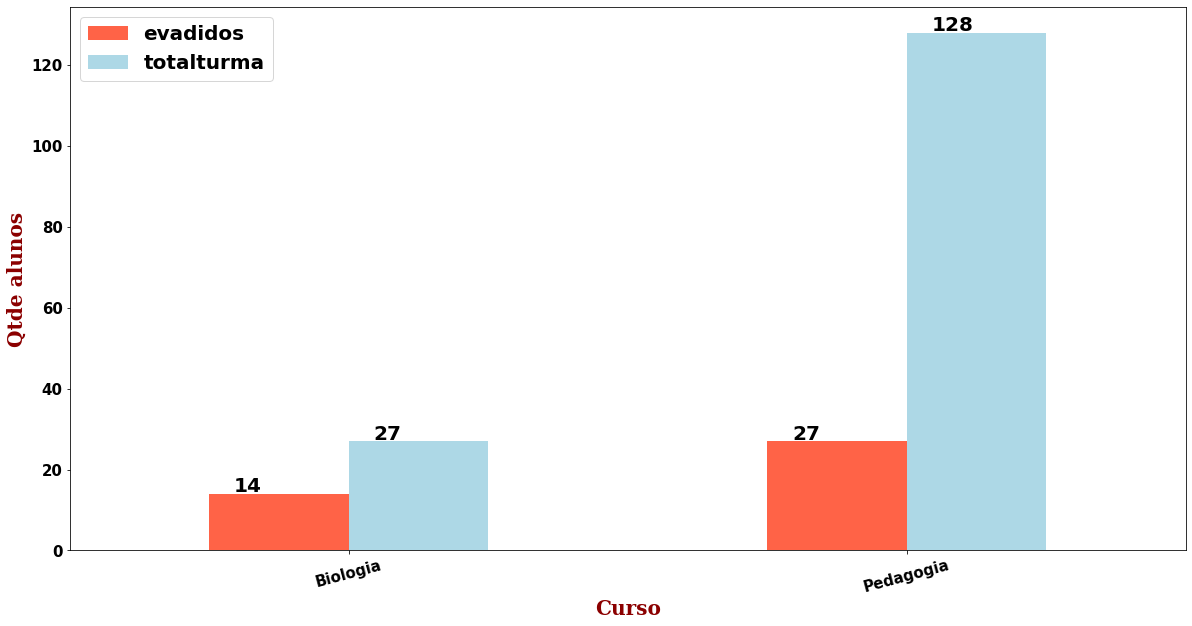

,Curso,totalturma,evadidos,perc_evadidos
0,Biologia,27,14,51.85
1,Pedagogia,128,27,21.09


In [ ]:
arcaboucoxai.analise_expl_dados.plota_situacao_evasao(arcaboucoxai.df_)

,var01,var02,var03,var10,var12,var13,var16,var17,var20,var21,var26,var27,var29
count,6654.00000,6654.000000,6654.000000,6654.000000,6654.000000,6654.000000,6654.000000,6654.000000,6654.000000,6654.000000,6654.000000,6654.000000,6654.000000
mean,3.11014,20.729336,29.945146,4.521913,20.402765,2.975503,7.653892,28.161407,4.289450,2.126991,3.461226,10.495191,3.468440
std,3.00232,24.244947,32.776385,3.985320,24.096132,2.117438,17.202842,27.074838,11.375414,7.057894,4.865970,2.162751,0.998185
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000
25%,1.12000,6.000000,7.000000,2.500000,6.000000,2.000000,0.000000,8.000000,0.000000,0.000000,0.000000,9.000000,3.000000
50%,2.62000,15.000000,22.000000,4.130000,15.000000,3.000000,1.000000,23.000000,0.000000,0.000000,2.000000,11.000000,4.000000
75%,4.31000,27.000000,42.000000,6.000000,27.000000,4.000000,9.000000,43.000000,2.000000,1.000000,6.000000,11.000000,4.000000
max,23.85000,296.000000,273.000000,76.140000,526.000000,26.000000,297.000000,264.000000,102.000000,97.000000,25.000000,17.000000,4.000000


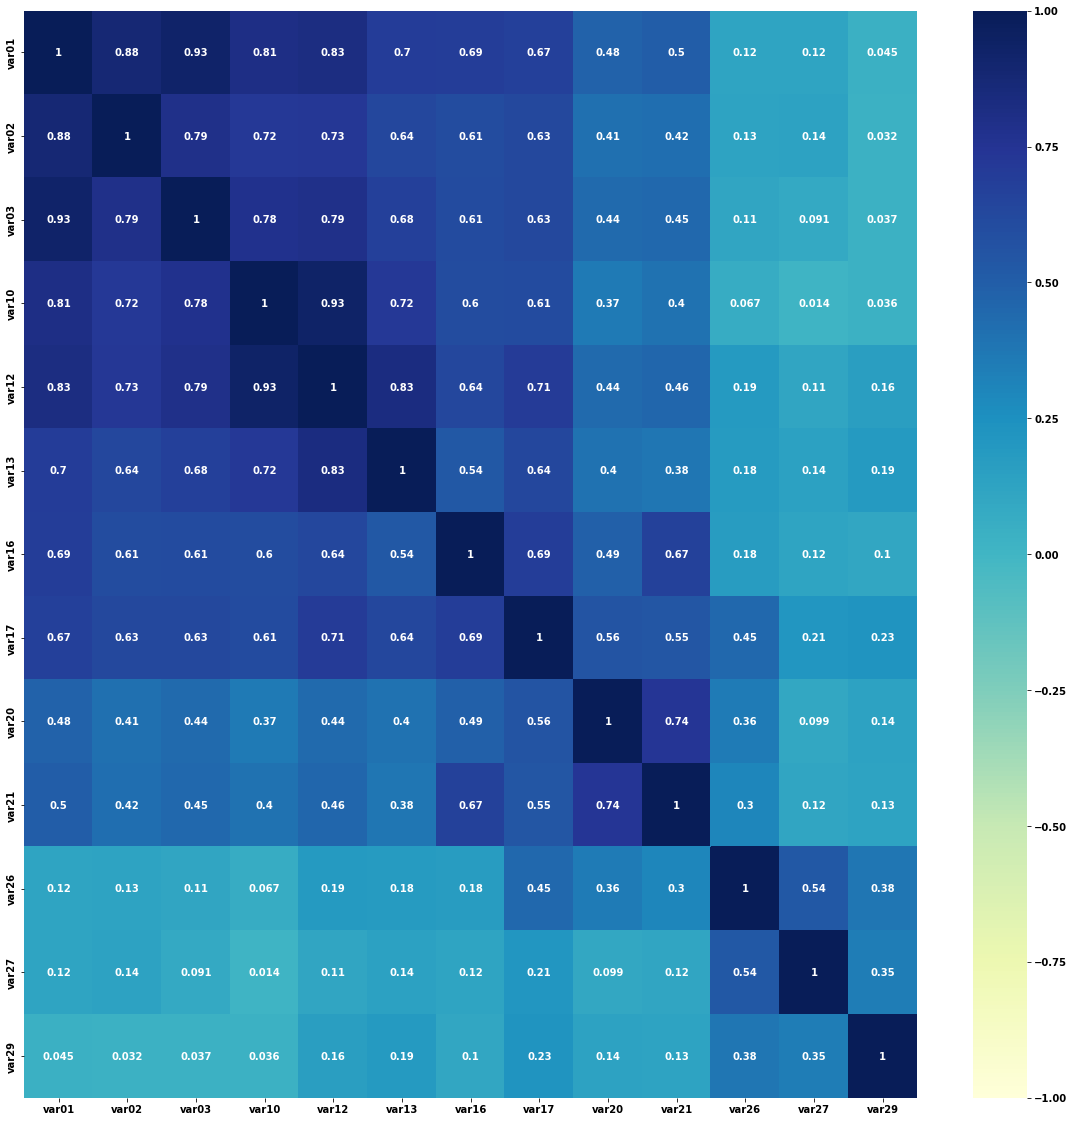

In [ ]:
arcaboucoxai.analise_expl_dados.plota_estat_dados(arcaboucoxai.df_)

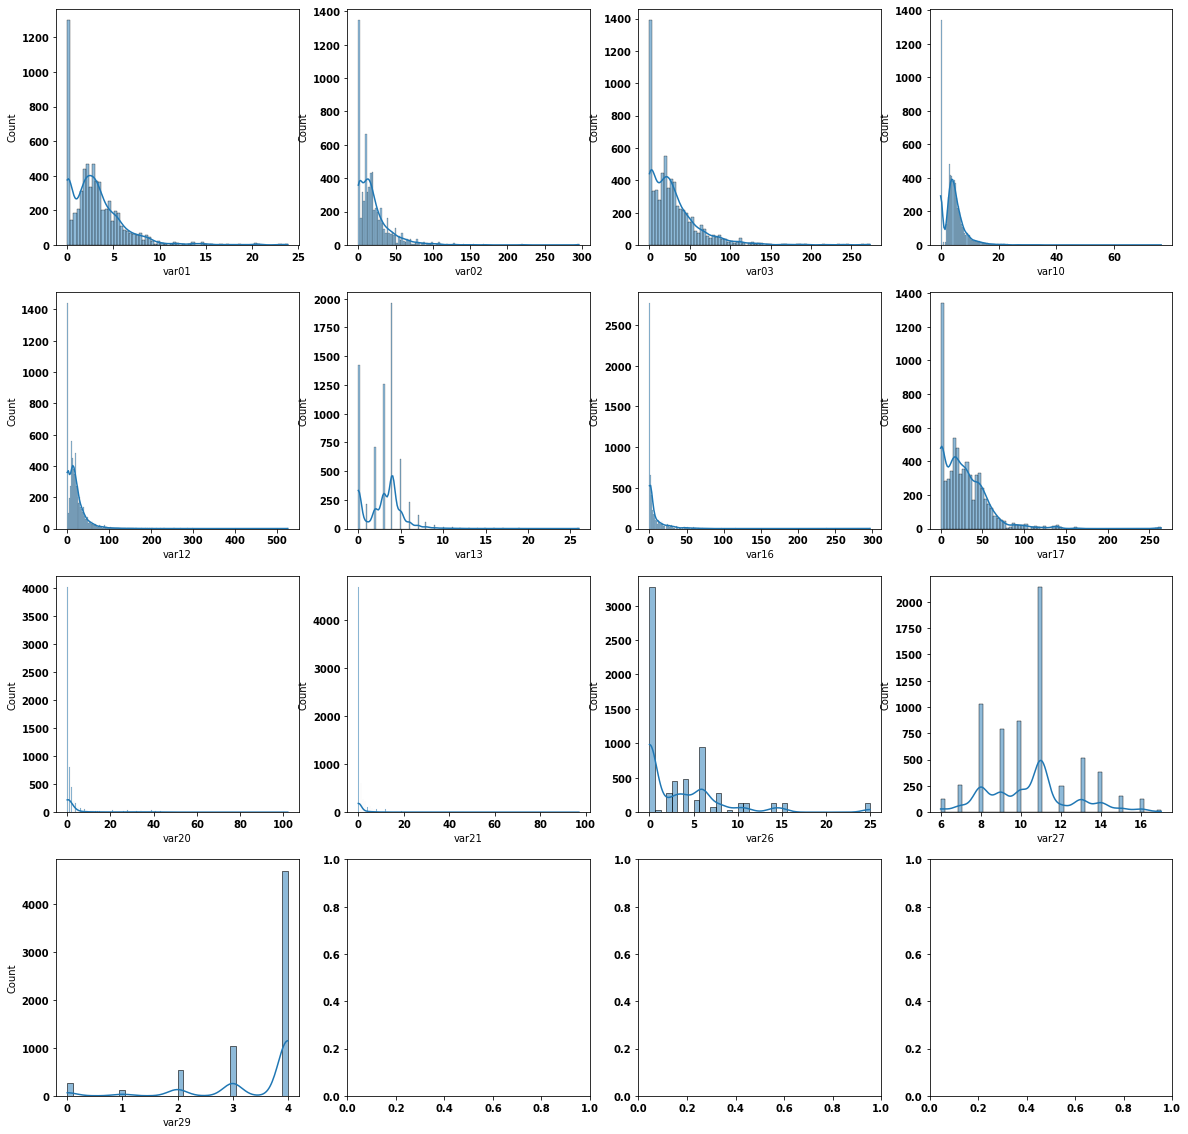

In [ ]:
arcaboucoxai.analise_expl_dados.plota_hist_dados(arcaboucoxai.df_)

In [ ]:
######### Apresenta as configurações definidas para o arcabouço #######
config_experimento.info()

Features selecionadas: ['var01', 'var02', 'var03', 'var10', 'var12', 'var13', 'var16', 'var17', 'var20', 'var21', 'var26', 'var27', 'var29']
Métricas utilizadas..: ['accuracy', 'recall', 'f1', 'precision', 'roc_auc', 'recall_macro']
Variável Alvo........: EVASAO
Executa balanceamento: True
Normalização.........: False
Remove outliers......: True
Utiliza otimiz Parâm.: True
Tipo Split de dados .: MonteCarlo
N_repeats Stratified.: 3
K_folds Stratified...: 5
Perc.Treinamento.....: 0.7
Perc.Teste...........: 0.3
Classificadores......:
{'nome_classificador': 'LR', 'classificador': LogisticRegression(), 'parametros': {'max_iter': [20, 50, 100, 200, 500, 1000, 2000, 5000], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'penalty': ['l2', 'none'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none']}, 'normaliza': True, 'executa_validacao': True, 'detalhe_treino': True, 'params_shap': {'tipo_explainer': 'agnostico', 'param_proba': 'predict_proba', 'check_additivity'

In [ ]:
############# Realiza alterações nas configurações dos classificadores ########
### Neste caso, define se será realizado o crossval para cada classificador ###
vstatmodcrossval = [{'nome_modelo':'LR','crossval':True},
                    {'nome_modelo':'KNN','crossval':True},
                    {'nome_modelo':'RF','crossval':True},
                    {'nome_modelo':'XGB','crossval':True},
                    {'nome_modelo':'CAT','crossval':False},
                    {'nome_modelo':'LGB','crossval':True}]

for vmodel in vstatmodcrossval:
 config_experimento.defval_cfg_modelo(vmodel['nome_modelo'],
                                      'executa_validacao',vmodel['crossval'])

# config_experimento.defval_cfg_modelo('RF','detalhe_treino',False)


-----Detecção e remoção de outliers-----
[0.45701067 0.13791159]
Dispersão da base original


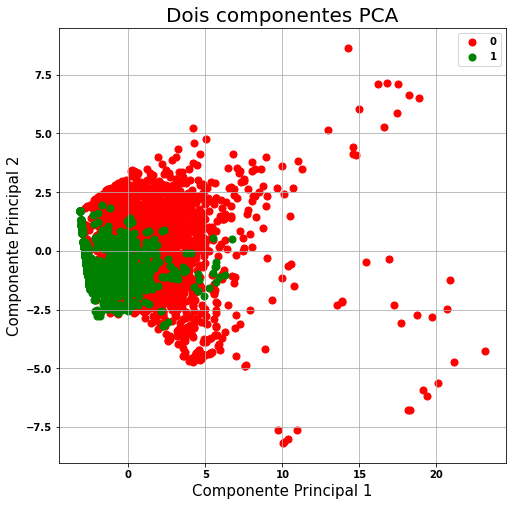

[0.4275162  0.14732145]
Dispersão depois de remoção de outliers


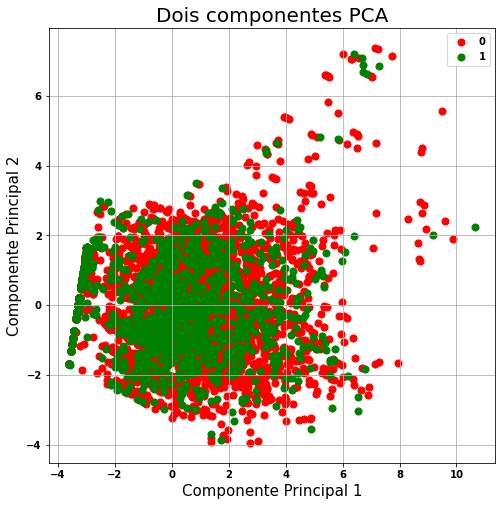

Concluído!
LR -Dados Normalizados:  True

-----Normalização dos dados para treinamento-----
Concluído!
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.89643 Média Crossval f1-score: 0.89059
   Melhor predição teste f1-score: 0.88931 Média teste f1-score...: 0.88507
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.90432 Média Crossval f1-score: 0.88686
   Melhor predição teste f1-score: 0.87690 Média teste f1-score...: 0.87390
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.91156 Média Crossval f1-score: 0.89874
   Melhor predição teste f1-score: 0.88364 Média teste f1-score...: 0.88133
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.90588 Média Crossval f1-score: 0.89372
   Melhor predição teste f1-score: 0.88160 Média teste f1-score...: 0.87677
Fitting 15 folds for each of 10 candi

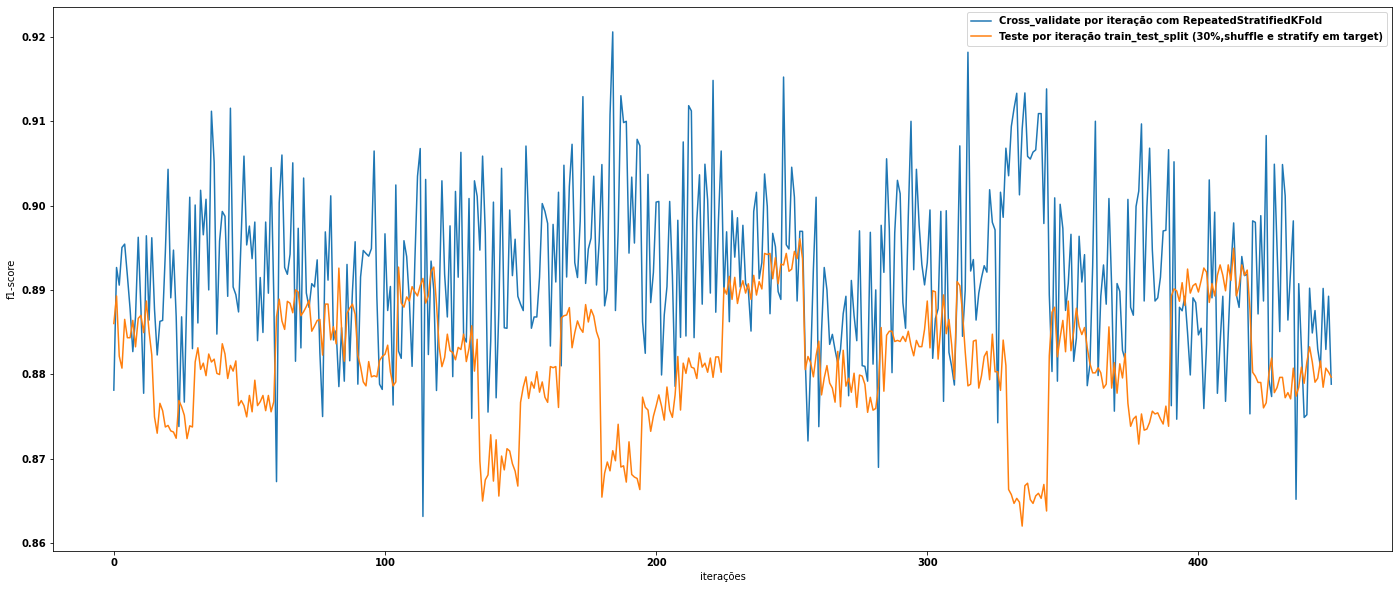

KNN -Dados Normalizados:  False

-----Sem normalização configurada para este classificador-----
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.97406 Média Crossval f1-score: 0.95993
   Melhor predição teste f1-score: 0.94251 Média teste f1-score...: 0.94005
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.97347 Média Crossval f1-score: 0.96471
   Melhor predição teste f1-score: 0.94232 Média teste f1-score...: 0.93669
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.95537 Média Crossval f1-score: 0.94524
   Melhor predição teste f1-score: 0.92715 Média teste f1-score...: 0.92397
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.95973 Média Crossval f1-score: 0.94924
   Melhor predição teste f1-score: 0.92904 Média teste f1-score...: 0.92343
Fitting 15 folds for each of 10 candidates, 

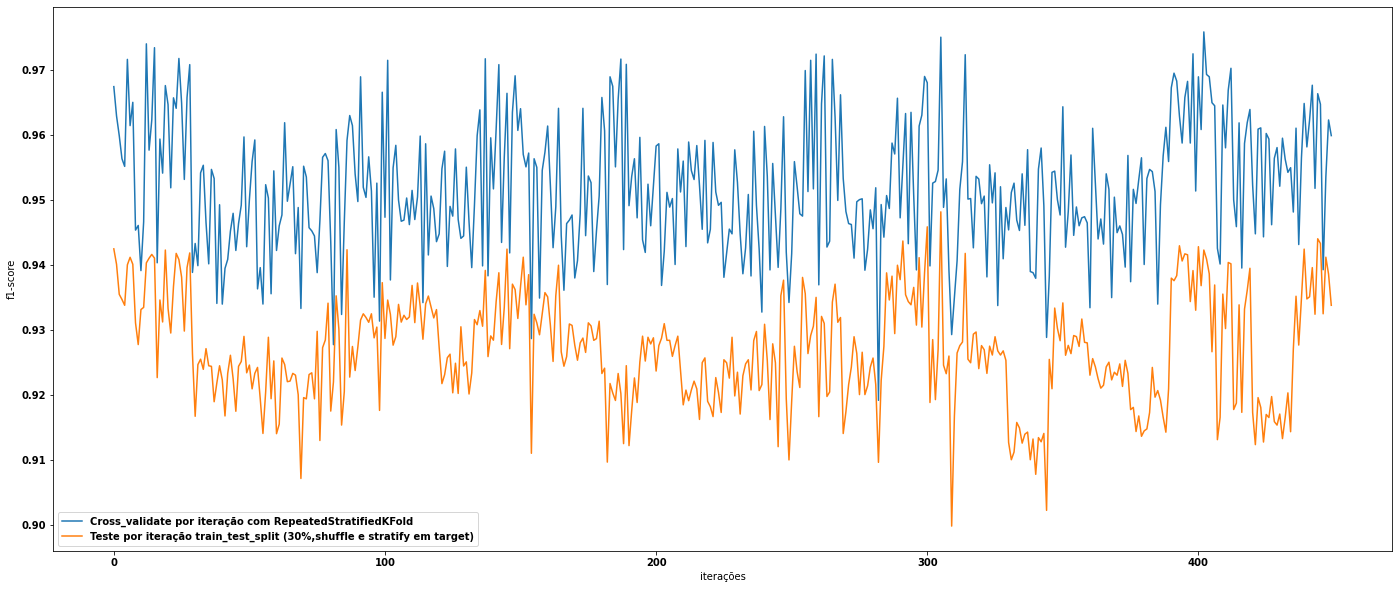

RF -Dados Normalizados:  False

-----Sem normalização configurada para este classificador-----
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.99254 Média Crossval f1-score: 0.98835
   Melhor predição teste f1-score: 0.97884 Média teste f1-score...: 0.97542
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.99172 Média Crossval f1-score: 0.98673
   Melhor predição teste f1-score: 0.98351 Média teste f1-score...: 0.97872
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.99171 Média Crossval f1-score: 0.98407
   Melhor predição teste f1-score: 0.98007 Média teste f1-score...: 0.97740
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.99008 Média Crossval f1-score: 0.98415
   Melhor predição teste f1-score: 0.98555 Média teste f1-score...: 0.98007
Fitting 15 folds for each of 10 candidates, t

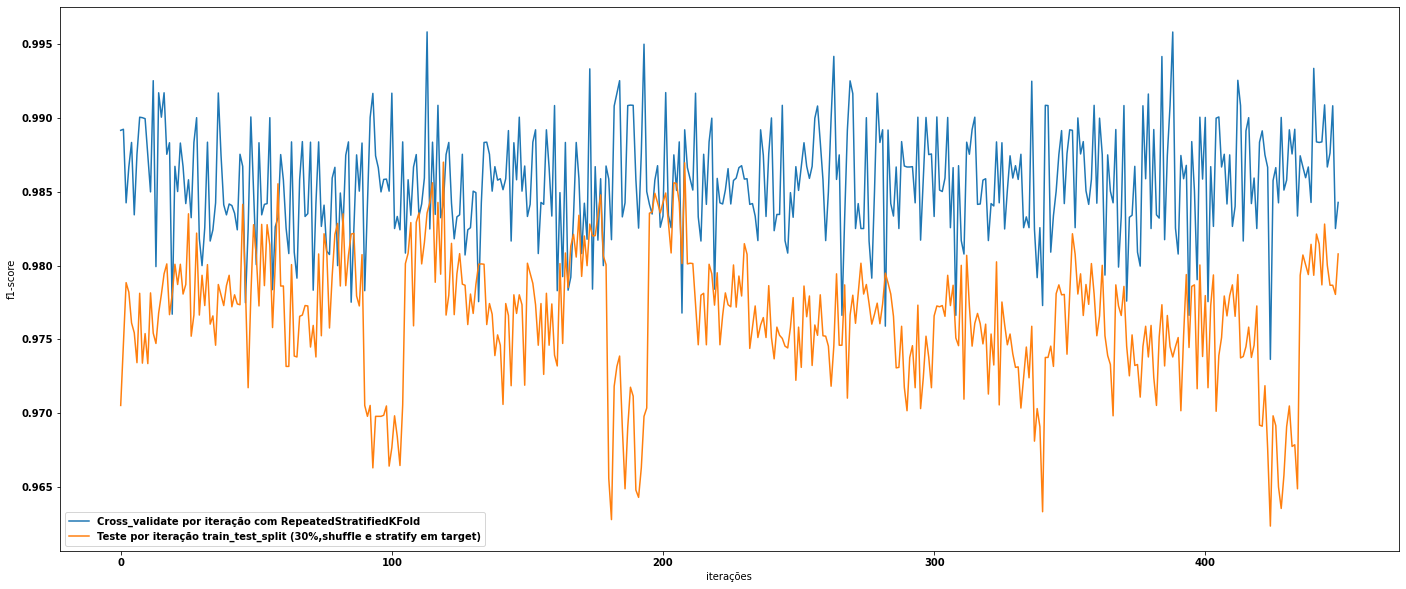

XGB -Dados Normalizados:  False

-----Sem normalização configurada para este classificador-----
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.99338 Média Crossval f1-score: 0.98923
   Melhor predição teste f1-score: 0.98367 Média teste f1-score...: 0.97894
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.99338 Média Crossval f1-score: 0.98753
   Melhor predição teste f1-score: 0.98702 Média teste f1-score...: 0.98492
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.99254 Média Crossval f1-score: 0.98841
   Melhor predição teste f1-score: 0.98699 Média teste f1-score...: 0.98359
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.99172 Média Crossval f1-score: 0.98671
   Melhor predição teste f1-score: 0.99110 Média teste f1-score...: 0.98151
Fitting 15 folds for each of 10 candidates, 

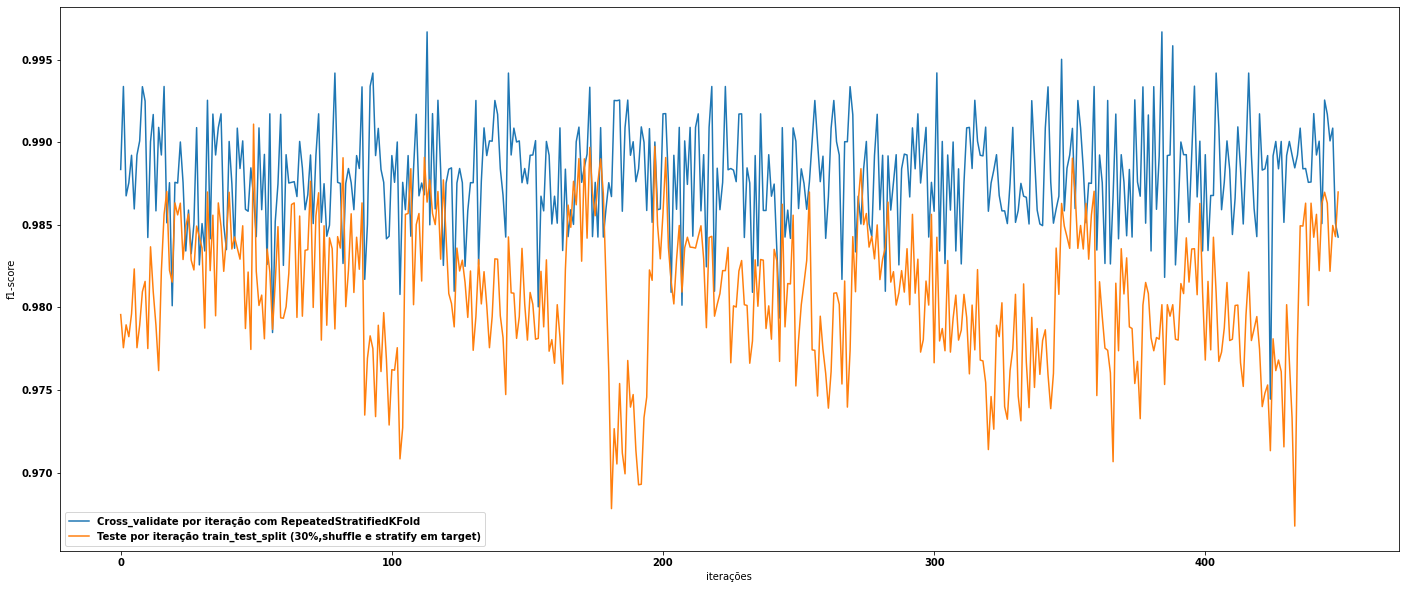

LGB -Dados Normalizados:  False

-----Sem normalização configurada para este classificador-----
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.99669 Média Crossval f1-score: 0.99008
   Melhor predição teste f1-score: 0.98774 Média teste f1-score...: 0.98638
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.99586 Média Crossval f1-score: 0.99086
   Melhor predição teste f1-score: 0.98974 Média teste f1-score...: 0.98700
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.99503 Média Crossval f1-score: 0.99087
   Melhor predição teste f1-score: 0.98973 Média teste f1-score...: 0.98699
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Melhor Crossval f1-score......: 0.99419 Média Crossval f1-score: 0.98849
   Melhor predição teste f1-score: 0.98973 Média teste f1-score...: 0.98629
Fitting 15 folds for each of 10 candidates, 

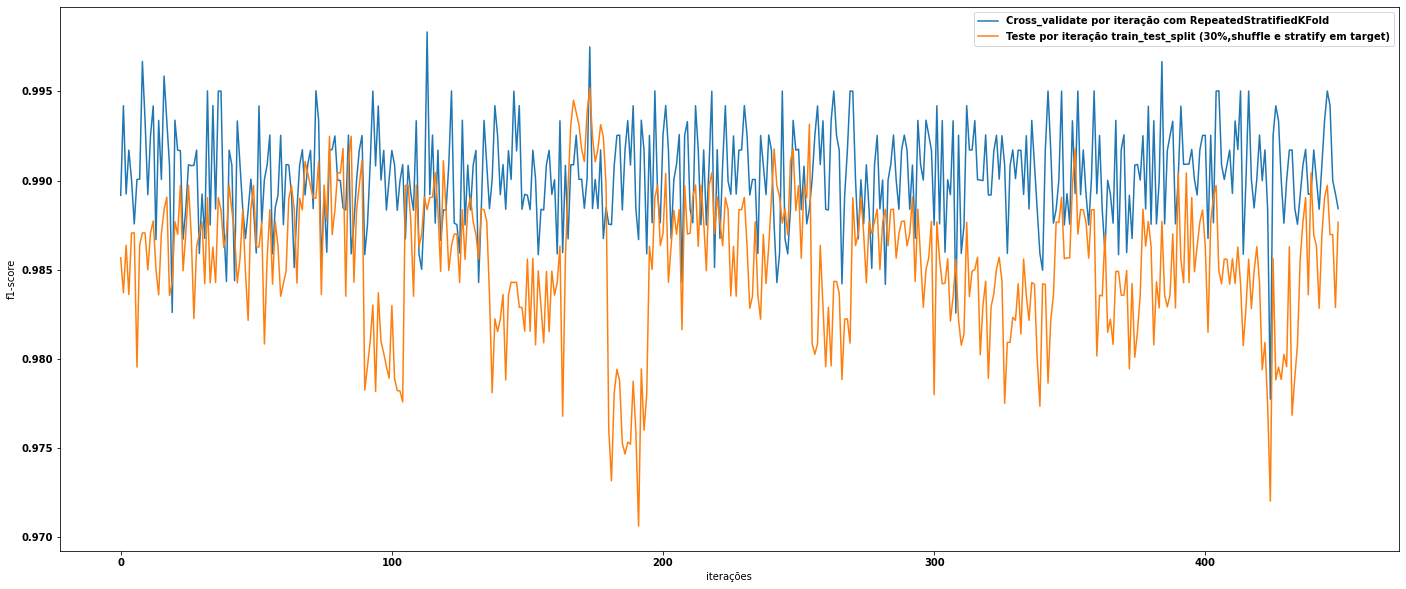

In [ ]:
##### Realiza Validação cruzada para os classificadores configurados ######
arcaboucoxai.exec_crossval_dados("Experimento UPE")

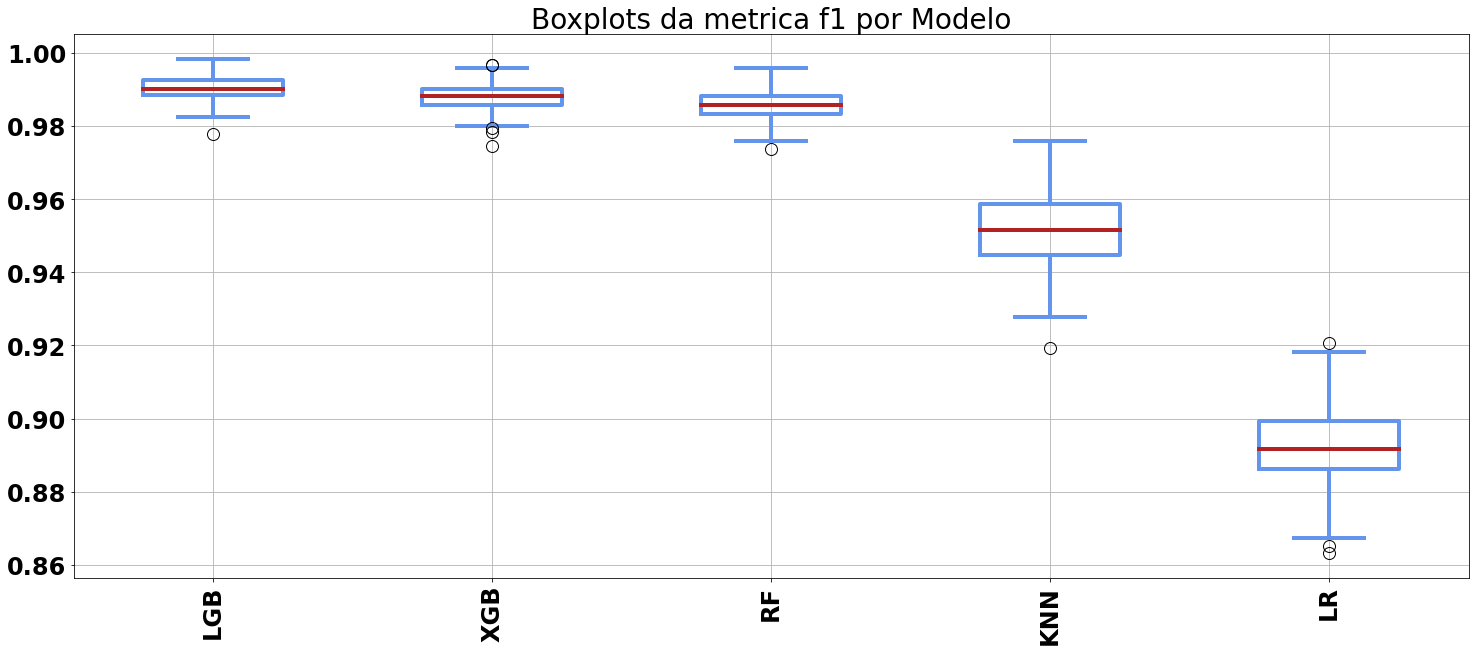

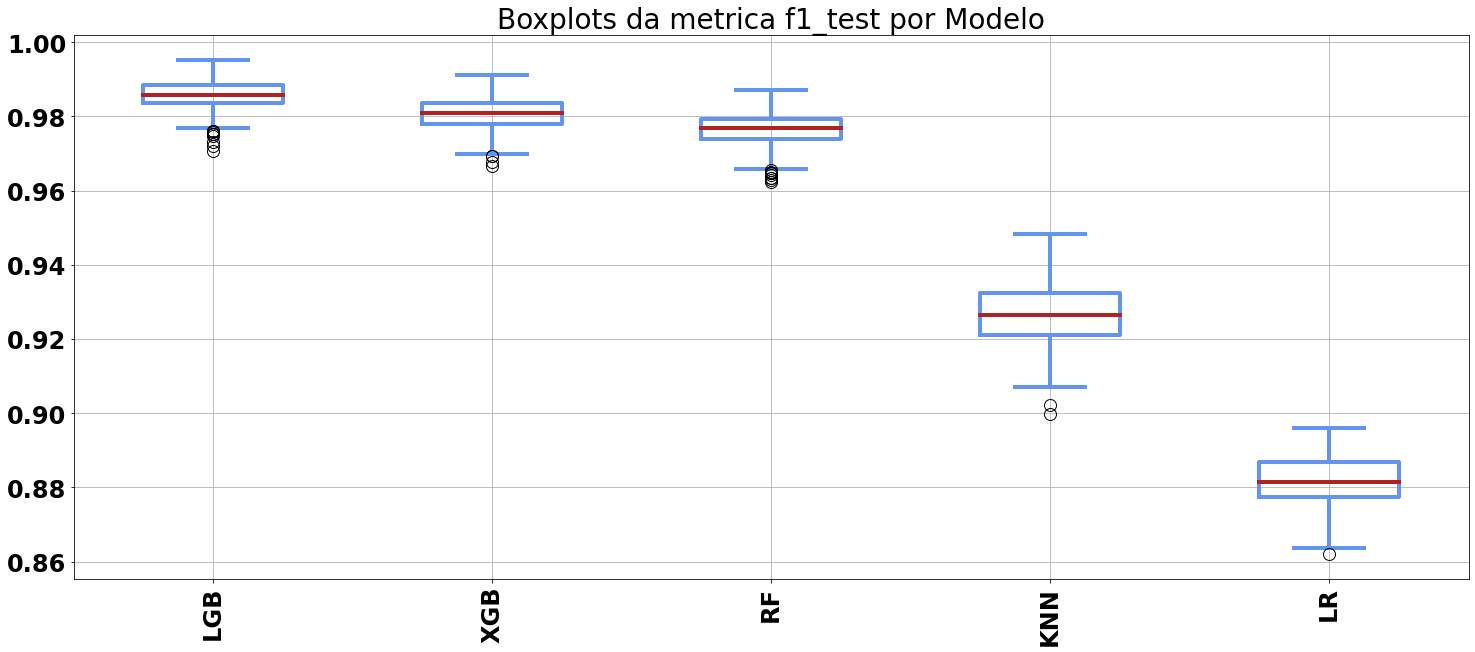

In [ ]:
######## Plota boxplot da validação cruzada ###########
arcaboucoxai.plota_boxplotcrossval("Experimento UPE")

In [ ]:
## Lista a frequência, para cada classificador, dos hiperparâmetros  testados ##
arcaboucoxai.lista_melhores_hiperp()

,modelo,hiperparam,qtde
11,XGB,"{'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.16}",22
10,XGB,"{'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 1.0}",6
12,XGB,"{'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 50, 'learning_rate': 0.16}",2
9,RF,"{'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}",30
5,LR,"{'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 5000, 'class_weight': 'balanced', 'C': 1}",10
7,LR,"{'solver': 'saga', 'penalty': 'none', 'max_iter': 20, 'class_weight': 'none', 'C': 100}",9
8,LR,"{'solver': 'saga', 'penalty': 'none', 'max_iter': 500, 'class_weight': 'balanced', 'C': 0.001}",7
4,LR,"{'solver': 'lbfgs', 'penalty': 'none', 'max_iter': 50, 'class_weight': 'balanced', 'C': 10}",2
6,LR,"{'solver': 'sag', 'penalty': 'l2', 'max_iter': 100, 'class_weight': 'none', 'C': 100}",2
2,LGB,"{'num_leaves': 1200, 'n_estimators': 200, 'max_depth': 75, 'learning_rate': 0.1}",15


In [ ]:
###### Realiza o teste de wilcoxon por pares nos resultados dos modelos#####
arcaboucoxai.exec_testwilcoxon('f1_test')

LR -> KNN WilcoxonResult(statistic=0.0, pvalue=1.8524659289458015e-75)
LR -> RF WilcoxonResult(statistic=0.0, pvalue=1.852471078383219e-75)
LR -> XGB WilcoxonResult(statistic=0.0, pvalue=1.8524607795226475e-75)
LR -> LGB WilcoxonResult(statistic=0.0, pvalue=1.852471078383219e-75)
KNN -> LR WilcoxonResult(statistic=0.0, pvalue=1.8524659289458015e-75)
KNN -> RF WilcoxonResult(statistic=0.0, pvalue=1.8524762278349491e-75)
KNN -> XGB WilcoxonResult(statistic=0.0, pvalue=1.8524762278349491e-75)
KNN -> LGB WilcoxonResult(statistic=0.0, pvalue=1.8524762278349491e-75)
RF -> LR WilcoxonResult(statistic=0.0, pvalue=1.852471078383219e-75)
RF -> KNN WilcoxonResult(statistic=0.0, pvalue=1.8524762278349491e-75)
RF -> XGB WilcoxonResult(statistic=2700.5, pvalue=1.1830806345991476e-67)
RF -> LGB WilcoxonResult(statistic=0.0, pvalue=1.8524195846453334e-75)
XGB -> LR WilcoxonResult(statistic=0.0, pvalue=1.8524607795226475e-75)
XGB -> KNN WilcoxonResult(statistic=0.0, pvalue=1.8524762278349491e-75)
XGB -

In [ ]:
#### Salva os resultados da validação cruzada para todos os modelos tesados ###
arcaboucoxai.salva_df(arcaboucoxai.df_results_crossval,'df_resultados_UPE.xlsx')

In [ ]:
### Altera configurações para que possa realizada crossval apenas no classifica-
### dor CAT
vstatmodcrossval = [{'nome_modelo':'LR','crossval':False},
                    {'nome_modelo':'KNN','crossval':False},
                    {'nome_modelo':'RF','crossval':False},
                    {'nome_modelo':'XGB','crossval':False},
                    {'nome_modelo':'CAT','crossval':True},
                    {'nome_modelo':'LGB','crossval':False}]

for vmodel in vstatmodcrossval:
 config_experimento.defval_cfg_modelo(vmodel['nome_modelo'],'executa_validacao',vmodel['crossval'])

In [ ]:
#### Executa o crossval sem resetar os resultados já obtidos para os outros
#### Classificadores
arcaboucoxai.reset_crossval = False
arcaboucoxai.exec_crossval_dados("Experimento UPE")

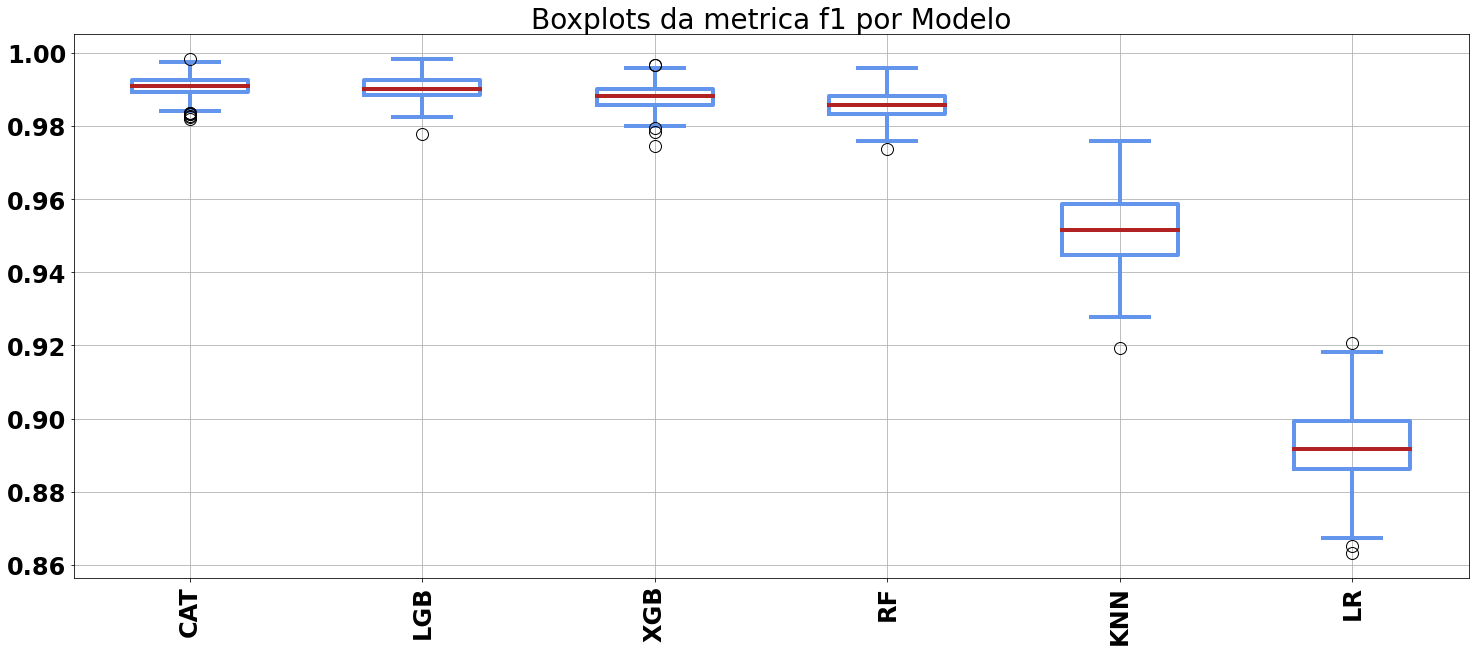

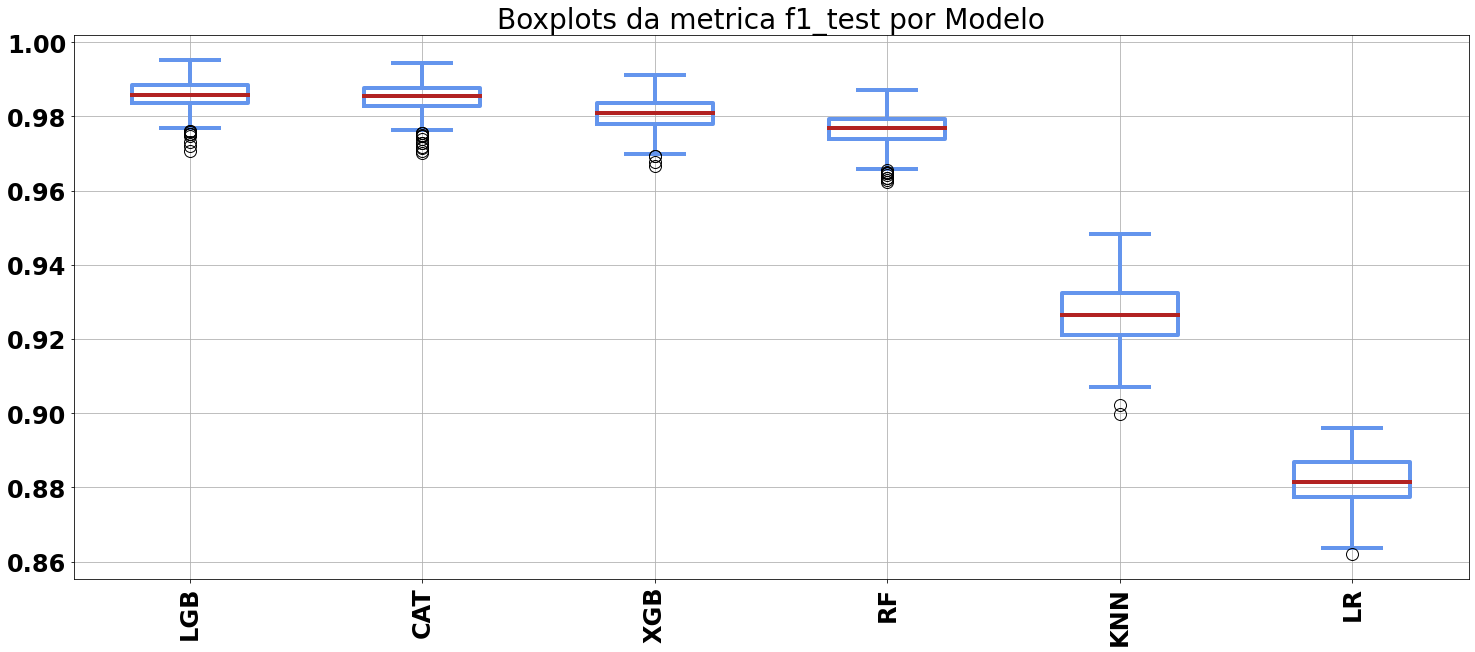

In [ ]:
arcaboucoxai.plota_boxplotcrossval("Experimento UPE")

In [ ]:
arcaboucoxai.salva_df(arcaboucoxai.df_results_crossval,'df_resultados_UPE.xlsx')

In [ ]:
###### Exemplo de como utilizar métodos da classe preprocessamento ########
# nome_curso_reduzidos = []
# nome_curso_reduzidos.append(['ADMINISTRACAO - BACHAREL EM ADMINISTRACAO','ADMINISTRACAO'])
# nome_curso_reduzidos.append(['ENGENHARIA CIVIL - ENGENHEIRO CIVIL','ENGENHARIA CIVIL'])
# nome_curso_reduzidos.append(['SISTEMAS DE INFORMACAO  - BACHAREL EM SISTEMAS DE INFORMACAO','SISTEMAS DE INFORMAÇÃO'])
# nome_curso_reduzidos.append(['SUPERIOR DE TECNOLOGIA EM GESTAO DE RECURSOS HUMANOS - TECNOLOGO EM RECURSOS HUMANOS','RECURSOS HUMANOS'])
# nome_curso_reduzidos.append(['SUPERIOR DE TECNOLOGIA EM DESIGN GRAFICO - TECNOLOGO EM DESIGN GRAFICO','DESIGN GRAFICO'])
# nome_curso_reduzidos.append(['PEDAGOGIA - LICENCIATURA - PEDAGOGO','PEDAGOGIA'])
# for nome in nome_curso_reduzidos:
#   arcaboucoxai.df_ = arcaboucoxai.preprocessamento.renomear_conteudo_campo(nome[0],nome[1],arcaboucoxai.df_)

Dados Normalizados:  False

-----Detecção e remoção de outliers-----
[0.45701067 0.13791159]
Dispersão da base original


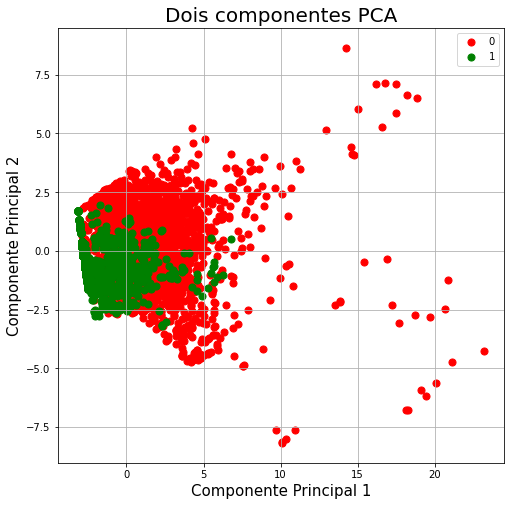

[0.4275162  0.14732145]
Dispersão depois de remoção de outliers


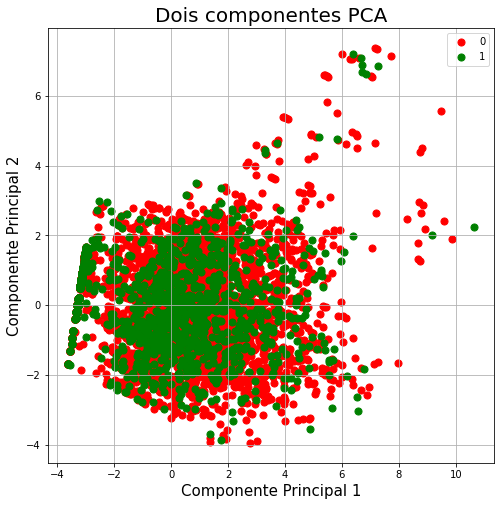

Concluído!

-----Balanceamento dos dados com SMOTE-----
Counter({0: 4301, 1: 1687}) Counter({0: 4301, 1: 4301})
Concluído!

-----Sem normalização configurada para este classificador-----
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Best normalized gini score for 5-fold search: 0.9934897819499056
   Best hyperparameters: {'num_leaves': 900, 'n_estimators': 200, 'max_depth': 25, 'learning_rate': 0.1}
LGBMClassifier(max_depth=25, n_estimators=200, num_leaves=900)

-----Efetuando cálculo de Shap Values para os dados de treinamento-----
Modelo:  LGB


100%|===================| 8598/8602 [06:34<00:00]       

Concluído!


In [ ]:
##### Realiza Treinamento com o modelo escolhido após análise dos resultados da
##### Validação cruzada

### Já passando os hiperparâmetros 
# arcaboucoxai.exec_treino_modelo('LGB','Experimento Exemplo',
#                            params={'num_leaves': 900,
#                                    'n_estimators': 200, 
#                                    'max_depth': 25, 'learning_rate': 0.1})

### Sem passar os hiperparâmetros
arcaboucoxai.exec_treino_modelo('LGB','Experimento sem hiper')

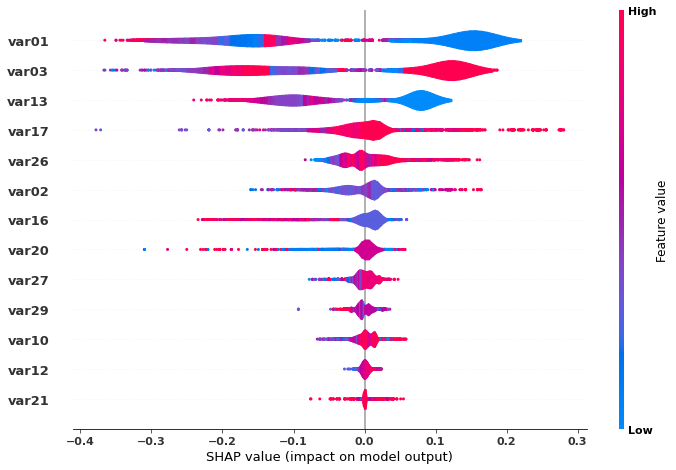

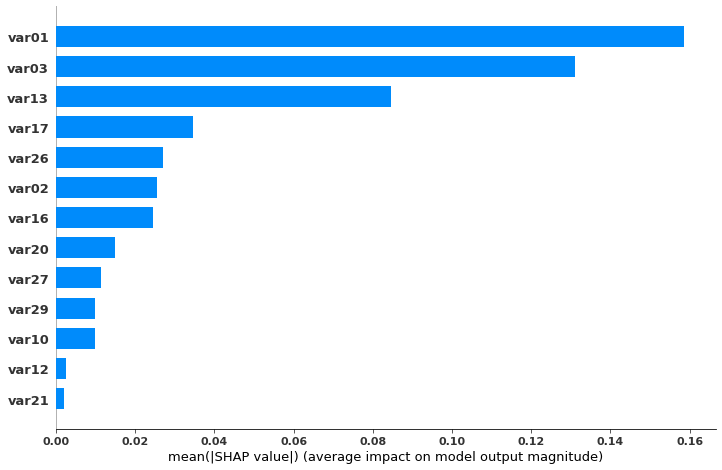

[13:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 62%|██████▏   | 8/13 [00:00<?, ?it/s]

[13:15:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 77%|███████▋  | 10/13 [00:10<00:00,  4.23it/s]

[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 85%|████████▍ | 11/13 [00:11<00:00,  3.11it/s]

[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

 92%|█████████▏| 12/13 [00:11<00:00,  2.64it/s]

[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

100%|██████████| 13/13 [00:12<00:00,  2.47it/s]

[13:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

14it [00:12,  2.14s/it]

[13:16:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


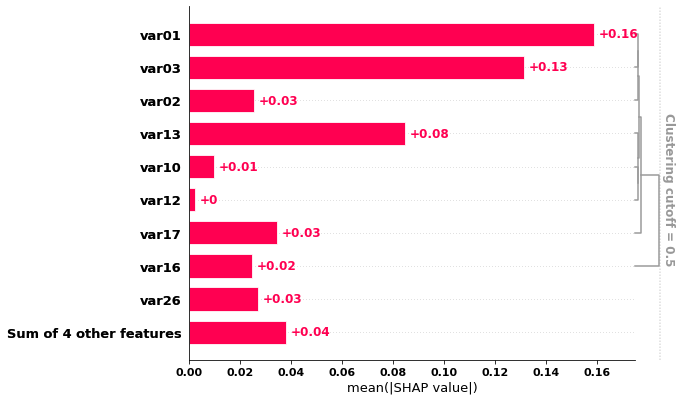

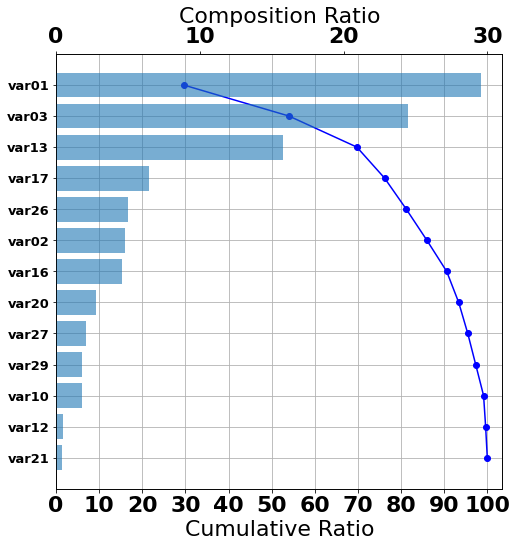

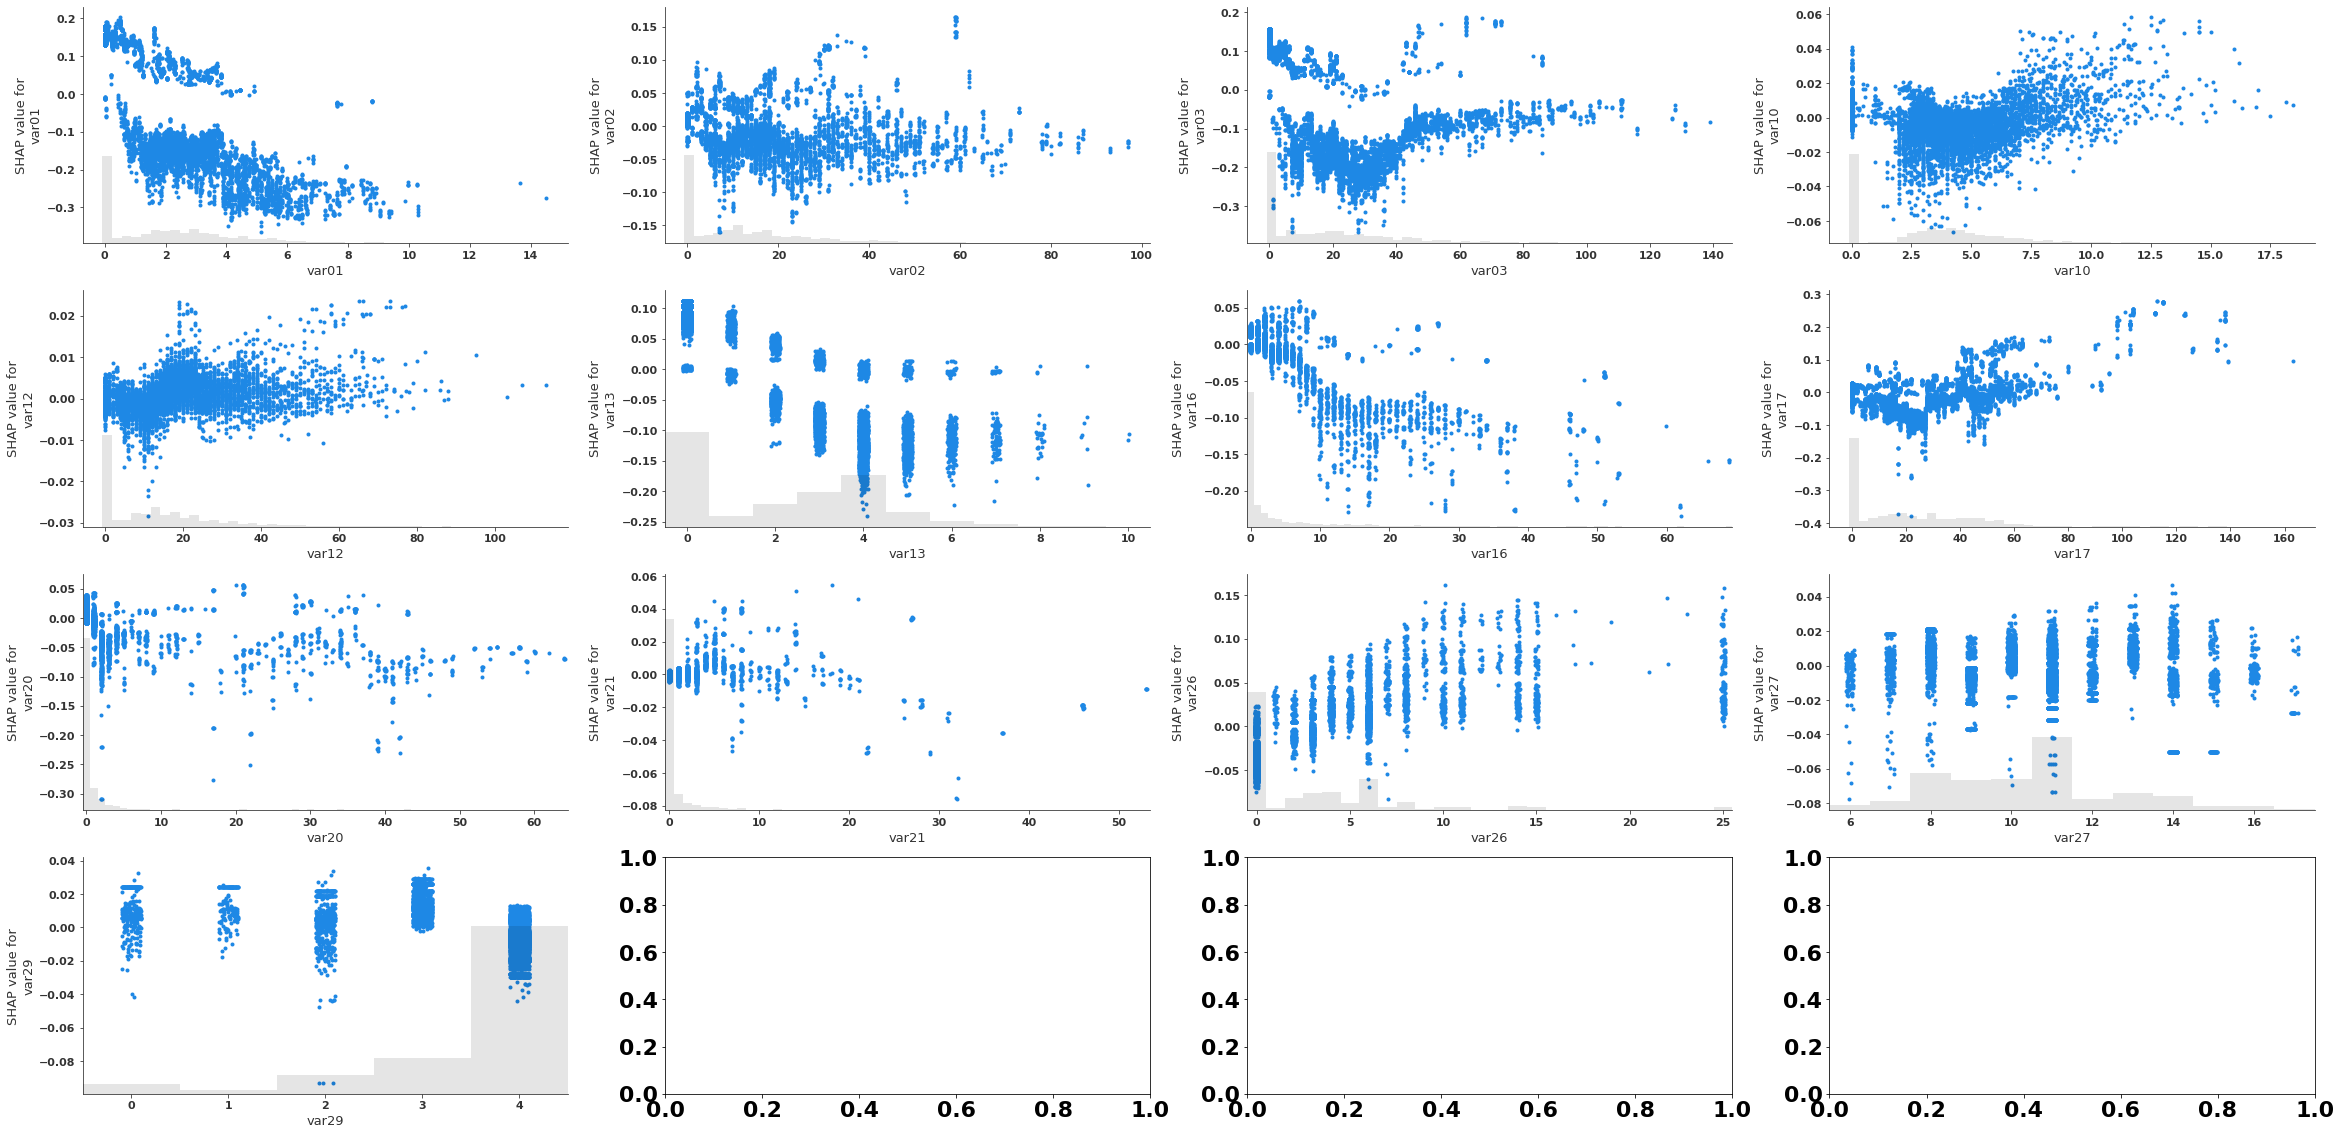

In [ ]:
#### Plota os gráficos SHAP para análise importância global (treinamento) ####
arcaboucoxai.analise_Xai.plota_sumario_beeswarm("Experimento teste")
arcaboucoxai.analise_Xai.plota_sumario_bar("Experimento teste")
arcaboucoxai.analise_Xai.plota_sumario_bardend("Experimento teste")
arcaboucoxai.analise_Xai.plota_waterfall_impacto("Experimento teste")
### Correção das variáveis independentes com a dependente
arcaboucoxai.analise_Xai.plota_scatter_corrtarget_var("Experimento teste")

In [ ]:
###### Excução do método wrapper de seleção de atributos para tentar confirmar
###### os atributos importantes para o modelo preditivo
arcaboucoxai.exec_wrapper_borutashap()

**Gráficos SHAP para análise explicabilidade local: Exemplo com a outra base UNIVALE**

In [ ]:
config_experimento.featuresselecionadas = ['med_ac_lti_sema_disc', 'tmp_medutil_semanahr',
       'med_geral_ac_sema_aluno', 'med_ac_lti_aluno_sema_disc',
       'qtde_reprov_disc', 'qtde_rep_prim_modulo', 'qtde_aprov_prim_modulo',
       'qtde_rep_curso', 'qtde_reprov_ult_modulo', 'qtde_trancamento_curso',
       'qtde_evasao_instituicao', 'qtde_cursos_concluidos_instituicao',
       'idade', 'med_difip_ac_sema_aluno', 'sexo', 'periodo_modulo',
       'med_ac_manha_sema_aluno', 'med_ac_tarde_sema_aluno',
       'med_ac_noite_sema_aluno', 'med_ac_madruga_sema_aluno']

In [ ]:
config_experimento.var_y = 'situacao'

In [ ]:
arcaboucoxai.carrega_arq_treino('Treino27092022.v2.xlsx',tipoarquivo='xlsx')

In [ ]:
config_experimento.featuresselecionadas = ['med_ac_lti_sema_disc','tmp_medutil_semanahr',
                        'med_ac_manha_sema_aluno','med_ac_tarde_sema_aluno',
                        'med_ac_noite_sema_aluno',
                        'med_ac_madruga_sema_aluno',
                        'qtde_aprov_prim_modulo',
                        'idade',
                        'med_difip_ac_sema_aluno',
                        'periodo_modulo',
                        'perc_reprov_disc',
                        'qtde_cursos_concluidos_instituicao',
                        'perc_acess_lti']

arcaboucoxai.df_['perc_acess_lti'] = np.where(
    arcaboucoxai.df_['med_ac_lti_sema_disc'] > 0,
    arcaboucoxai.df_['med_ac_lti_aluno_sema_disc']/
    arcaboucoxai.df_['med_ac_lti_sema_disc'],0)

arcaboucoxai.df_['perc_reprov_disc'] = arcaboucoxai.df_['perc_reprov_disc']/100

Dados Normalizados:  False

-----Detecção e remoção de outliers-----
[0.29765048 0.13832828]
Dispersão da base original


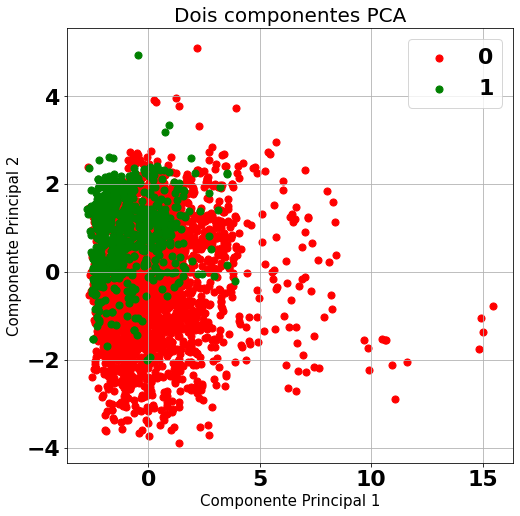

[0.25883559 0.14565171]
Dispersão depois de remoção de outliers


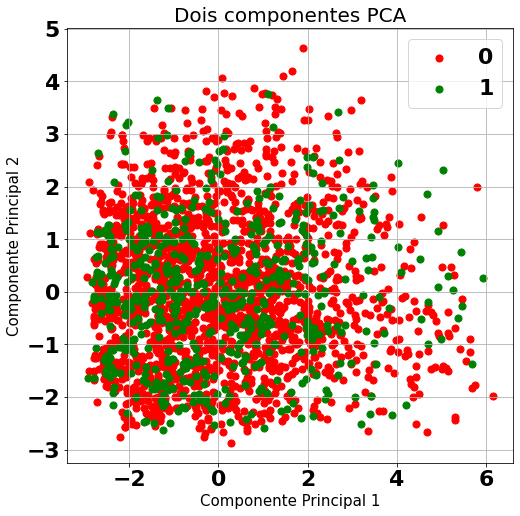

Concluído!

-----Balanceamento dos dados com SMOTE-----
Counter({0: 2158, 1: 610}) Counter({1: 2158, 0: 2158})
Concluído!

-----Sem normalização configurada para este classificador-----
Fitting 15 folds for each of 10 candidates, totalling 150 fits
   Best normalized gini score for 5-fold search: 0.9782195289885701
   Best hyperparameters: {'num_leaves': 900, 'n_estimators': 200, 'max_depth': 25, 'learning_rate': 0.1}
LGBMClassifier(max_depth=25, n_estimators=200, num_leaves=900)

-----Efetuando cálculo de Shap Values para os dados de treinamento-----
Modelo:  LGB


100%|===================| 4309/4316 [03:06<00:00]       

Concluído!


In [ ]:
##### Realiza treinamento do modelo LGB
arcaboucoxai.exec_treino_modelo('LGB','Experimento sem hiper')

In [ ]:
dfteste = pd.read_excel('Dadosteste2022.1.v2.xlsx')
dfteste['perc_acess_lti'] = np.where(dfteste['med_ac_lti_sema_disc'] > 0,dfteste['med_ac_lti_aluno_sema_disc']/dfteste['med_ac_lti_sema_disc'],0)
dfteste['perc_reprov_disc'] = dfteste['perc_reprov_disc']/100
dfteste = dfteste.drop(dfteste[(dfteste['med_ac_lti_sema_disc'] == 0) & (dfteste['tmp_medutil_semanahr'] > 0) & (dfteste['med_geral_ac_sema_aluno'] == 0)].index,axis=0)
dfteste['tmp_medutil_semanahr'] = np.where((dfteste['med_geral_ac_sema_aluno'] == 0) & (dfteste['tmp_medutil_semanahr'] > 0),0,dfteste['tmp_medutil_semanahr'])

LGBMClassifier(max_depth=25, n_estimators=200, num_leaves=900)

-----Sem normalização configurada para este classificador-----


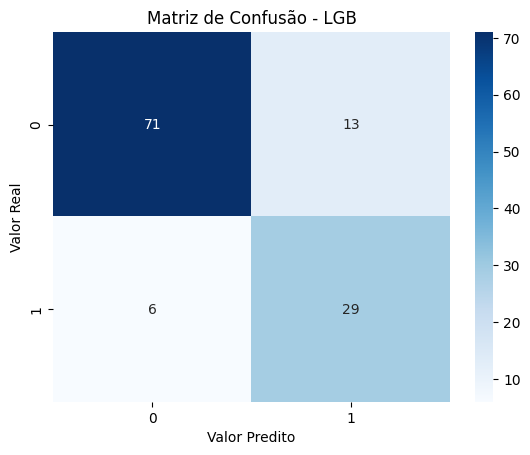

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        84
           1       0.69      0.83      0.75        35

    accuracy                           0.84       119
   macro avg       0.81      0.84      0.82       119
weighted avg       0.85      0.84      0.84       119

ROC-AUC  0.8369047619047619
Concluído!


In [ ]:
#### Executa a predição com dados de um período ############
arcaboucoxai.exec_predicao_modelo(dfteste.drop(dfteste[dfteste['periodo_modulo'] != 5].index, axis=0))

In [ ]:
#### Exibe o Dataframe com os dados do teste e a predição realizada
#### com a probabilidade da situação de evasão (proba_1)
arcaboucoxai.dfpredicteste

,prediction,proba_1,situacao,situacao_disc,curso,semestre,periodo_modulo,disciplina,aluno,med_ac_lti_sema_disc,...,totalmodulos,status_disc,status_curso,tipo_ingresso,turma,med_ac_manha_sema_aluno,med_ac_tarde_sema_aluno,med_ac_noite_sema_aluno,med_ac_madruga_sema_aluno,perc_acess_lti
0,0,0.0000,0,0,BACHAREL EM ADMINISTRACAO,2022.1,5,FUNDAMENTOS DE ECONOMIA,DAVILA PATRICIA SILVA PAIVA,3,...,6,Aprovado,Pré-Matriculado,Processo Seletivo,2021.1,4,1,1,0,0.000000
1,0,0.0000,0,0,BACHAREL EM ADMINISTRACAO,2022.1,5,FUNDAMENTOS DE ECONOMIA,ELAINE RODRIGUES ALVES,3,...,6,Aprovado,Pré-Matriculado,PROUNI,2021.1,0,2,2,0,0.333333
2,0,0.0000,0,0,BACHAREL EM ADMINISTRACAO,2022.1,5,FUNDAMENTOS DE ECONOMIA,FILIPPO MANIACI,3,...,10,Aprovado,Pré-Matriculado,Processo Seletivo,2020.1,0,1,1,1,0.000000
3,0,0.0000,0,0,BACHAREL EM ADMINISTRACAO,2022.1,5,FUNDAMENTOS DE ECONOMIA,LARA BEATRIZ ALVES FERREIRA,3,...,6,Aprovado,Pré-Matriculado,Indefinido,2021.1,2,1,1,0,0.333333
4,0,0.0000,0,0,BACHAREL EM ADMINISTRACAO,2022.1,5,FUNDAMENTOS DE ECONOMIA,MATHEUS PACHECO MAGALHAES,3,...,6,Aprovado,Pré-Matriculado,Indefinido,2021.1,1,1,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,1,0.9956,1,1,TECNOLOGO EM DESIGN GRAFICO,2022.1,5,WEBDESIGN E LINGUAGEM DE PROGRAMACAO,RAFAELA CAROLINA MATHINA DE OLIVEIRA,5,...,5,Pré-Matriculado,Pré-Matriculado,Processo Seletivo,2021.1,0,0,0,0,0.000000
115,0,0.0000,0,0,TECNOLOGO EM DESIGN GRAFICO,2022.1,5,WEBDESIGN E LINGUAGEM DE PROGRAMACAO,RAFFAEL DE LIMA OLIVEIRA,5,...,9,Aprovado,Pré-Matriculado,PROUNI,2020.3,0,0,1,0,0.200000
116,1,0.9919,0,0,TECNOLOGO EM DESIGN GRAFICO,2022.1,5,WEBDESIGN E LINGUAGEM DE PROGRAMACAO,STHEFANIA KAROLINY GONCALVES FARIA,5,...,5,Aluno Transferido,Transferência Interna,Processo Seletivo,2021.3,0,0,0,0,0.000000
117,0,0.0000,0,0,TECNOLOGO EM RECURSOS HUMANOS,2022.1,5,AVALIACAO DO DESEMPENHO DAS PESSOAS,ANGELICA CARVALHO RIBEIRO,6,...,6,Aprovado,Pré-Matriculado,Processo Seletivo,2021.1,1,1,1,0,0.000000


In [ ]:
### Novo DataFrame com os erros encontados na predição
diferencas = arcaboucoxai.dfpredicteste[
    arcaboucoxai.dfpredicteste['prediction'] != 
    arcaboucoxai.dfpredicteste[config_experimento.var_y]]

In [ ]:
### Lista o DataFrame das diferenças
diferencas.head()

Pesquisa de aluno : DAVI HOT MIRA Disciplina:  DESIGN E DESENVOLVIMENTO DE BANCO DE DADOS


<Figure size 20000x15000 with 0 Axes>

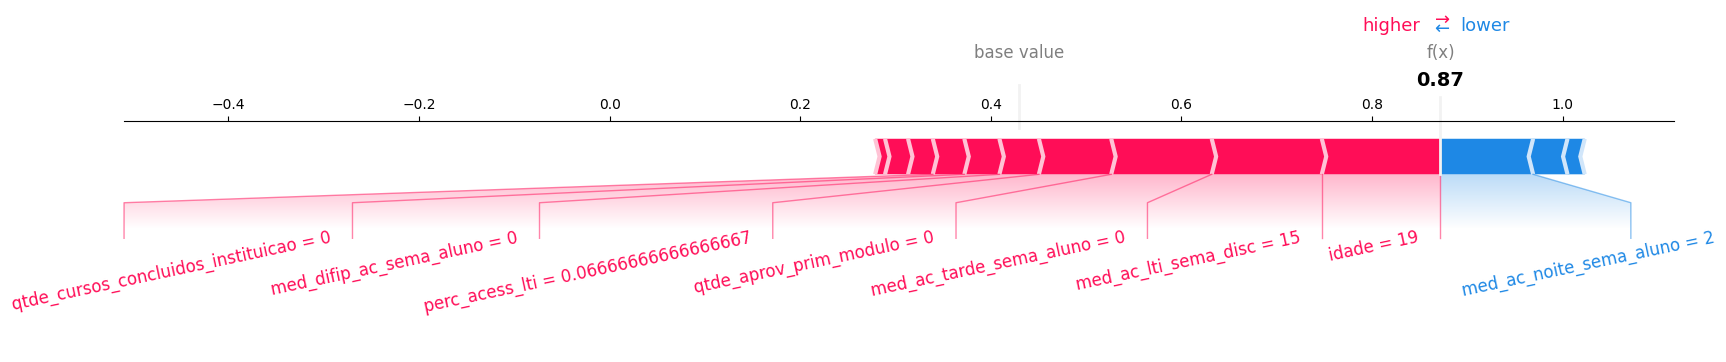

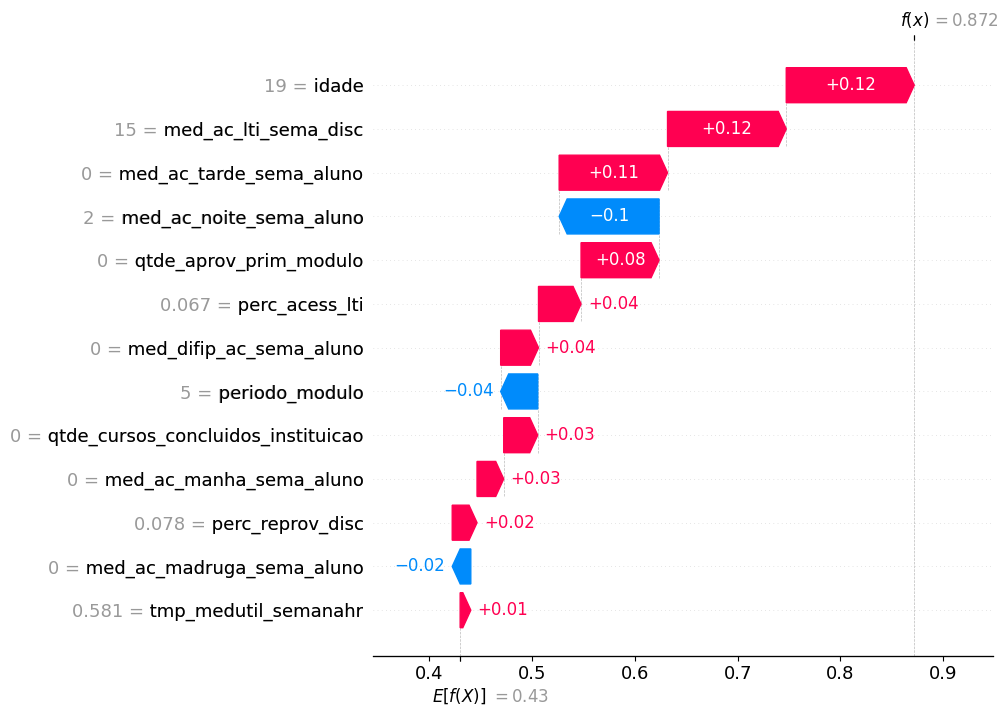

Pesquisa de aluno : DAVI HOT MIRA Disciplina:  ESTRUTURA DE DADOS


<Figure size 20000x15000 with 0 Axes>

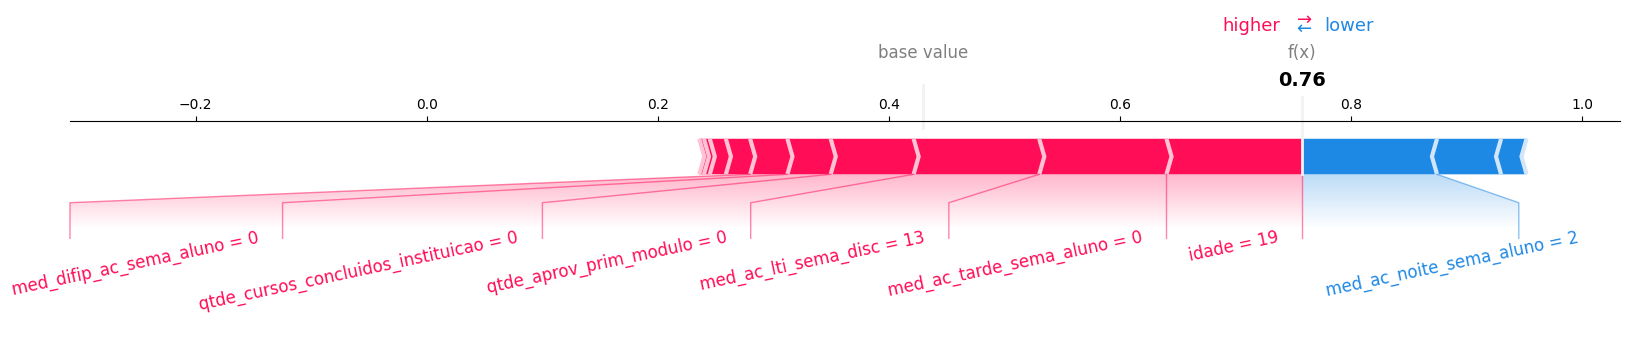

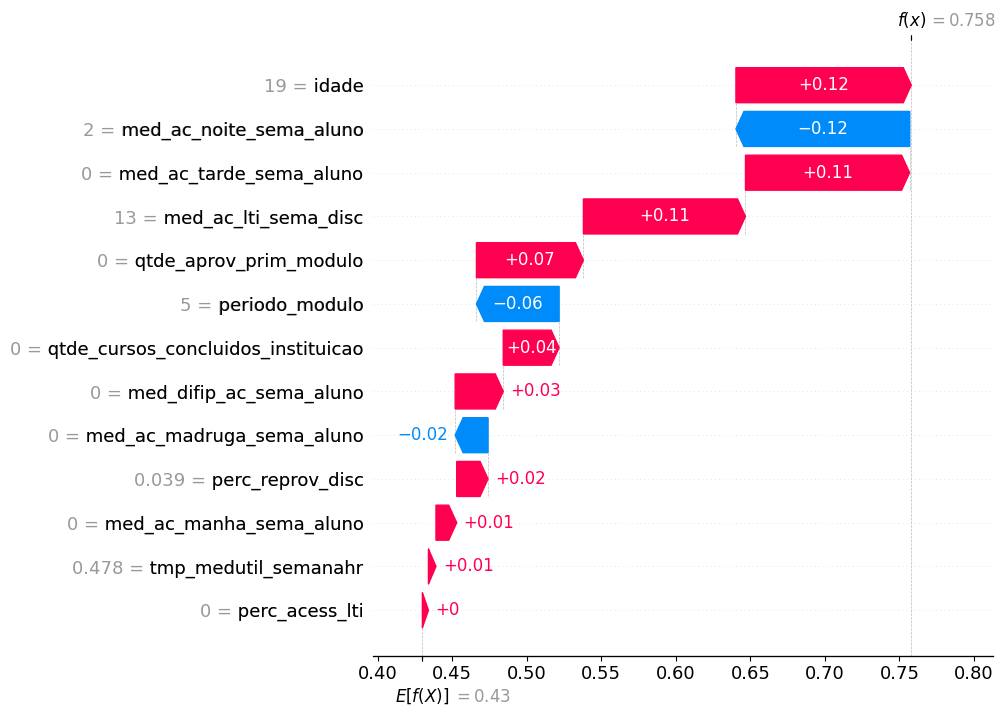

In [ ]:
##### Plota os gráficos de força que as variáveis exerceram para o resultado
##### do modelo preditivo (interpretabilidade local)
arcaboucoxai.analise_Xai.executa_xai_local('aluno','DAVI HOT MIRA',arcaboucoxai.dfpredicteste,'png')